In [23]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec
from IPython.display import display, Math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
#get ctd files 
files = glob.glob('../Dissertation_projects/Data/CTD/DOWNCAST_RENAME/*.csv') 

files

['../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.11_2128_07-25-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.13_2124_07-21-21_1.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.14_2122_07-19-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.15_2126_07-23-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.16_2127_07-24-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.2_2125_07-22-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.4_2121_07-17-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.5B_2120_07-16-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.7_2129_07-26-21_1.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.9_2123_07-20-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.MK_2119_07-15-21.csv',

In [3]:
#make vars 
stations = ['St.11', 'St.12', 'St.13', 'St.14-2', 'St.14', 'St.16-2',
            'St.16', 'St.2', 'St.4', 'St.6', 'St.7',
            'St.9', 'St.MK-2', 'St.MK', 'St.15', 'St.5B']
camps = ['GOM2021','GOM21FA', 'GOM22SP', 'GOM22SU']

select = camps[0] #0 to 2
selectstn = stations[0] #0 to 15

#pick out the vars you need
df1 = pd.read_csv(files[0])
cols_to_select = df1.columns.tolist()

#make the data frame 

frames = []

for f in files: 
    df = pd.read_csv(f)
    
    ID = f.split("\\")[1]
    ID = ID[:-4].split("_")
    
    camp = ID[1]
    station = ID[2]
    sample_id = ID[3]
    date = ID[4]
    
    maxd = df['Pressure [dbar]'].max()
    lat = df['latitude'].mean()
    lon = df['longitude'].mean()
    
    df_new = df.loc[:, cols_to_select]
    
    df_new['camp'] = camp
    df_new['station'] = station
    df_new['sample_id'] = sample_id
    df_new['date'] = date
    df_new['maxd'] = maxd
    df_new['lat'] = lat
    df_new['lon'] = lon
    
    frames.append(df_new)
    
ds = pd.concat(frames, axis=0)

ds_copy = ds['wetCDOM'].copy()
ds_copy.loc[ds_copy < -1] = np.nan
ds_copy.loc[ds_copy > 125] = np.nan
ds = pd.merge(ds, ds_copy, left_index=True, right_index=True, how='outer')
ds = ds.rename(columns={'wetCDOM_x': 'wetCDOM', 'wetCDOM_y': 'wetCDOM_clean'})

ds['date_time'] = pd.to_datetime(ds['date'])
ds['dates'] = ds['date_time'].dt.date

# get the unique values for each group
station_vals = ds['station'].unique()
camp_vals = ds['camp'].unique()

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_16588\2879452403.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ds['date_time'] = pd.to_datetime(ds['date'])


In [4]:
ds

Pressure [dbar]  nbf     c0S/m  density00  wetCDOM  flECO-AFL  \
0                2.442  0.0  6.009679  1022.6337   0.4177     0.0300   
0                2.442  0.0  6.009679  1022.6337   0.4177     0.0300   
0                2.442  0.0  6.009679  1022.6337   0.4177     0.0300   
0                2.442  0.0  6.009679  1022.6337   0.4177     0.0300   
0                2.442  0.0  6.009679  1022.6337   0.4177     0.0300   
...                ...  ...       ...        ...      ...        ...   
61320          996.609  0.0  3.398890  1032.1919   6.1100     0.2100   
61321          996.625  0.0  3.398883  1032.1917   6.1100     0.1794   
61322          996.610  0.0  3.398800  1032.1908   6.1100     0.1794   
61323          996.576  0.0  3.398832  1032.1911   6.1100     0.1489   
61324          996.658  0.0  3.398909  1032.1921   6.1100     0.1794   

       latitude  longitude  sbeox0Mg/L           par  ...     camp  station  \
0      28.21658  -89.54686      7.3014  2.875700e+03  ...  GOM2021    St.11   
0      28.21658  -89.54686      7.3014  2.875700e+03  ...  GOM2021    St.11   
0      28.21658  -89.54686      7.3014  2.875700e+03  ...  GOM2021    St.11   
0      28.21658  -89.54686      7.3014  2.875700e+03  ...  GOM2021    St.11   
0      28.21658  -89.54686      7.3014  2.875700e+03  ...  GOM2021    St.11   
...         ...        ...         ...           ...  ...      ...      ...   
61320  28.59346  -88.88148      5.2669  1.000000e-12  ...  GOM22SU    St.12   
61321  28.59346  -88.88148      5.2672  1.000000e-12  ...  GOM22SU    St.12   
61322  28.59346  -88.88148      5.2676  1.000000e-12  ...  GOM22SU    St.12   
61323  28.59346  -88.88148      5.2679  1.000000e-12  ...  GOM22SU    St.12   
61324  28.59346  -88.88148      5.2683  1.000000e-12  ...  GOM22SU    St.12   

       sample_id      date     maxd        lat        lon wetCDOM_clean  \
0           2128  07-25-21  946.986  28.219226 -89.544687        0.4177   
0           2128  07-25-21  946.986  28.219226 -89.544687       -0.8131   
0           2128  07-25-21  946.986  28.219226 -89.544687       -0.0438   
0           2128  07-25-21  946.986  28.219226 -89.544687        3.3408   
0           2128  07-25-21  946.986  28.219226 -89.544687        6.5715   
...          ...       ...      ...        ...        ...           ...   
61320       2250   7-21-22  996.658  28.593868 -88.884425        6.1100   
61321       2250   7-21-22  996.658  28.593868 -88.884425        6.1100   
61322       2250   7-21-22  996.658  28.593868 -88.884425        6.1100   
61323       2250   7-21-22  996.658  28.593868 -88.884425        6.1100   
61324       2250   7-21-22  996.658  28.593868 -88.884425        6.1100   

       date_time       dates  
0     2021-07-25  2021-07-25  
0     2021-07-25  2021-07-25  
0     2021-07-25  2021-07-25  
0     2021-07-25  2021-07-25  
0     2021-07-25  2021-07-25  
...          ...         ...  
61320 2022-07-21  2022-07-21  
61321 2022-07-21  2022-07-21  
61322 2022-07-21  2022-07-21  
61323 2022-07-21  2022-07-21  
61324 2022-07-21  2022-07-21  

[13997542 rows x 26 columns]

In [5]:
#Stats 
ds_ctd = ds
print(ds_ctd.columns)
ds_ctd = ds_ctd.reset_index(drop=True)

# Group by 'camp' and 'station' and extract the min and max 'Pressure [dbar]'
grouped = ds_ctd.groupby(['camp', 'station'])

# Functions to get the values associated with min and max pressures
def get_val_at_min_pressure(group, column):
    idx = group['Pressure [dbar]'].idxmin()
    return group.loc[idx, column]

def get_val_at_max_pressure(group, column):
    idx = group['Pressure [dbar]'].idxmax()
    return group.loc[idx, column]

# Aggregate data based on min and max pressures
summary = grouped.agg(
    dates=('dates', 'first'),
    maxd=('maxd', 'first'),
    Pressure_dbar_surface=('Pressure [dbar]', 'min'),
    O2_mgL_surface=('sbeox0Mg/L', lambda x: get_val_at_min_pressure(ds_ctd.loc[x.index], 'sbeox0Mg/L')),
    latitude_surface=('latitude', lambda x: get_val_at_min_pressure(ds_ctd.loc[x.index], 'latitude')),
    longitude_surface=('longitude', lambda x: get_val_at_min_pressure(ds_ctd.loc[x.index], 'longitude')),
    Pressure_dbar_bottom=('Pressure [dbar]', 'max'),
    O2_mgL_bottom=('sbeox0Mg/L', lambda x: get_val_at_max_pressure(ds_ctd.loc[x.index], 'sbeox0Mg/L')),
    latitude_bottom=('latitude', lambda x: get_val_at_max_pressure(ds_ctd.loc[x.index], 'latitude')),
    longitude_bottom=('longitude', lambda x: get_val_at_max_pressure(ds_ctd.loc[x.index], 'longitude'))
)

# Rename columns
summary = summary.rename(columns={'camp': 'campaign', 'maxd': 'Max_pressure', 'dates': 'date'})

# Reset index
O2_summary = summary.reset_index()
O2_summary

Index(['Pressure [dbar]', 'nbf', 'c0S/m', 'density00', 'wetCDOM', 'flECO-AFL',
       'latitude', 'longitude', 'sbeox0Mg/L', 'par', 'sal00', 't090C', 't068C',
       'timeM', 'turbWETbb0', 'flag', 'camp', 'station', 'sample_id', 'date',
       'maxd', 'lat', 'lon', 'wetCDOM_clean', 'date_time', 'dates'],
      dtype='object')


camp  station        date  Max_pressure  Pressure_dbar_surface  \
0   GOM2021    St.11  2021-07-25       946.986                  2.076   
1   GOM2021    St.13  2021-07-21       321.519                  2.283   
2   GOM2021    St.14  2021-07-19        91.278                  1.829   
3   GOM2021    St.15  2021-07-23       287.295                  2.191   
4   GOM2021    St.16  2021-07-24        61.804                  1.277   
5   GOM2021     St.2  2021-07-22        63.413                  2.074   
6   GOM2021     St.4  2021-07-17        17.437                  1.145   
7   GOM2021    St.5B  2021-07-16        12.856                  1.505   
8   GOM2021     St.7  2021-07-26        39.529                  1.736   
9   GOM2021     St.9  2021-07-20        79.028                  2.283   
10  GOM2021    St.MK  2021-07-15        16.981                  1.760   
11  GOM2021    St.ML  2021-07-27        14.595                  1.620   
12  GOM21FA    St.11  2021-11-10       916.966                  1.556   
13  GOM21FA    St.12  2021-11-09       960.512                  1.881   
14  GOM21FA    St.13  2021-11-07       448.876                  1.312   
15  GOM21FA    St.14  2021-10-31        88.896                  1.433   
16  GOM21FA  St.14.5  2021-11-01       104.344                  1.866   
17  GOM21FA    St.15  2021-11-02       263.293                  1.864   
18  GOM21FA    St.16  2021-11-08        58.940                  1.698   
19  GOM21FA  St.16-2  2021-11-12        15.517                  1.770   
20  GOM21FA     St.2  2021-11-02        62.458                  1.174   
21  GOM21FA     St.4  2021-10-26        17.006                  1.211   
22  GOM21FA    St.5B  2021-10-25        12.869                  1.387   
23  GOM21FA     St.6  2021-10-25        13.849                  1.762   
24  GOM21FA     St.7  2021-10-31        38.371                  1.407   
25  GOM21FA     St.9  2021-11-01        81.090                  1.643   
26  GOM21FA    St.MK  2021-10-27        17.149                  2.164   
27  GOM21FA  St.MK-2  2021-10-30        13.611                  1.213   
28  GOM22SP    St.13  2022-04-18       557.668                  2.172   
29  GOM22SP    St.14  2022-04-09        88.922                  1.460   
30  GOM22SP    St.15  2022-04-16       263.450                  1.962   
31  GOM22SP    St.16  2022-04-11        57.412                  3.045   
32  GOM22SP     St.2  2022-04-17        63.432                  1.544   
33  GOM22SP     St.4  2022-04-20        16.450                  1.737   
34  GOM22SP    St.5B  2022-04-14        13.664                  1.508   
35  GOM22SP     St.7  2022-04-10        39.548                  1.165   
36  GOM22SP     St.9  2022-04-16        79.039                  1.549   
37  GOM22SP    St.MK  2022-04-19        17.800                  2.096   
38  GOM22SU    St.11  2022-07-22       945.291                  1.609   
39  GOM22SU    St.12  2022-07-21       996.658                  1.416   
40  GOM22SU    St.13  2022-07-18       487.498                  1.654   
41  GOM22SU    St.14  2022-07-16        86.455                  1.500   
42  GOM22SU    St.15  2022-07-15       266.624                  1.147   
43  GOM22SU    St.16  2022-07-20        57.999                  1.164   
44  GOM22SU     St.2  2022-07-19        62.421                  1.296   
45  GOM22SU     St.4  2022-07-10        17.075                  1.454   
46  GOM22SU    St.5B  2022-07-10        12.409                  1.496   
47  GOM22SU     St.7  2022-07-12        41.135                  1.457   
48  GOM22SU     St.9  2022-07-17        79.973                  1.672   
49  GOM22SU    St.MK  2022-07-23        17.611                  1.769   

    O2_mgL_surface  latitude_surface  longitude_surface  Pressure_dbar_bottom  \
0           7.3366          28.21678          -89.54664               946.986   
1           6.2980          28.53696          -89.49614               321.519   
2           6.3473          28.72514    

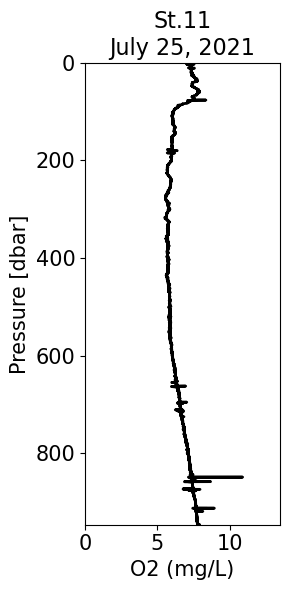

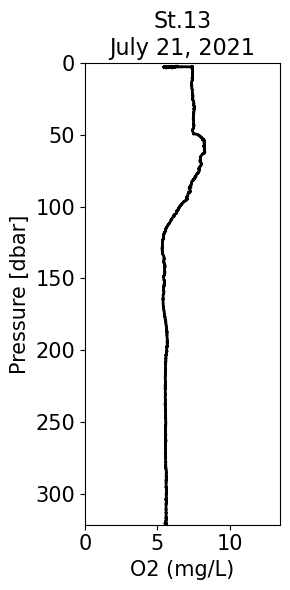

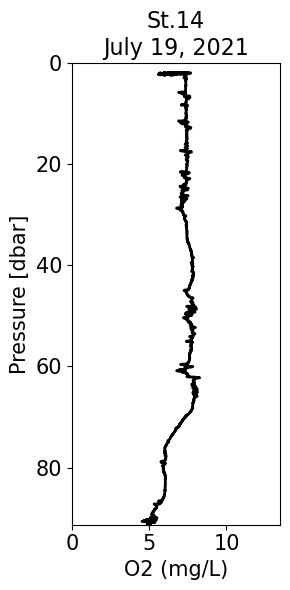

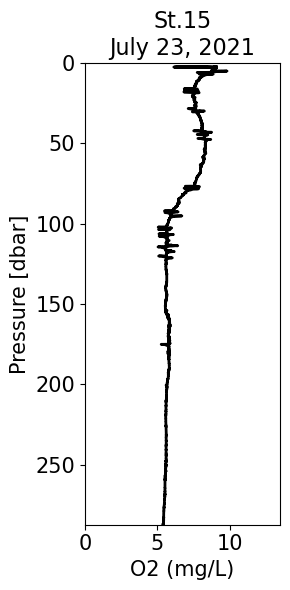

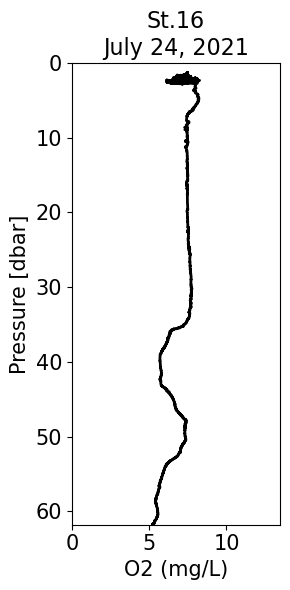

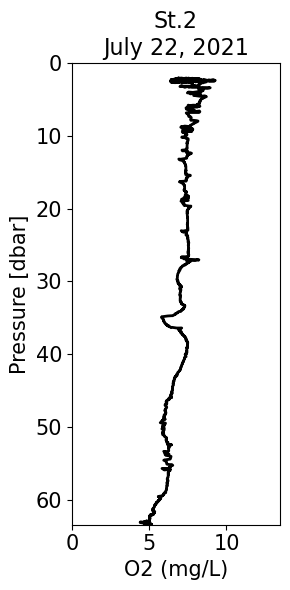

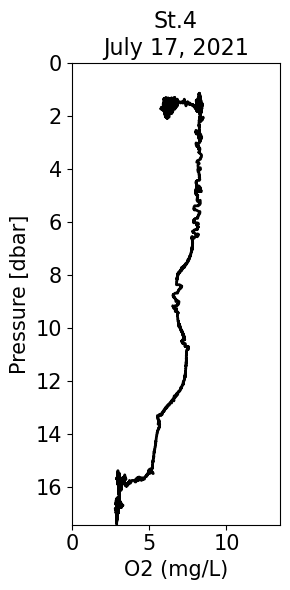

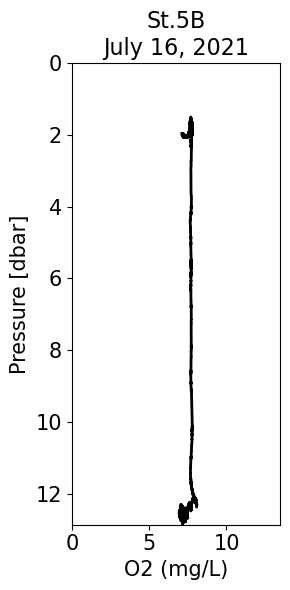

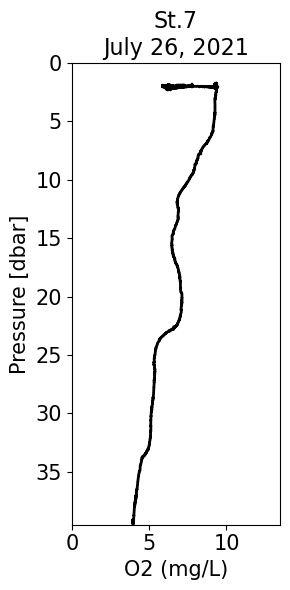

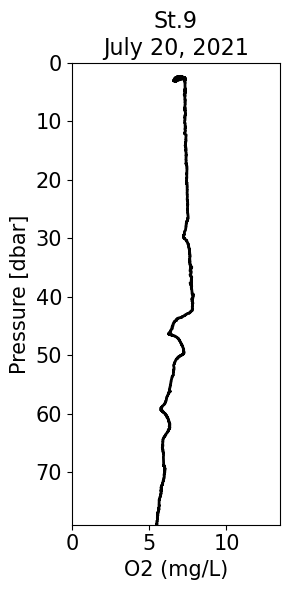

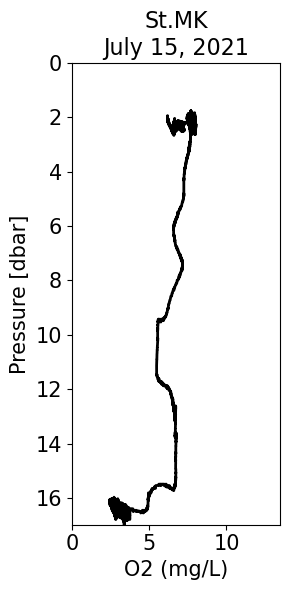

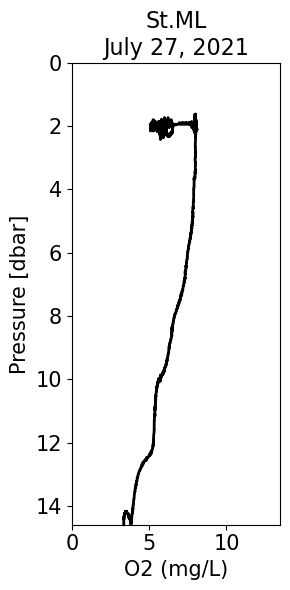

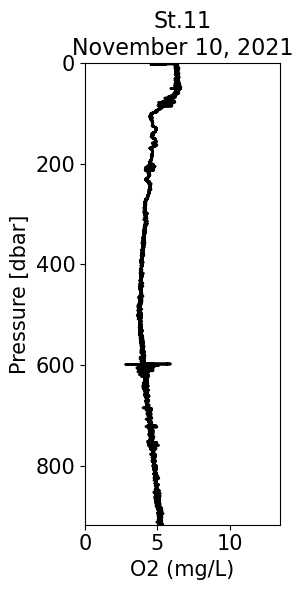

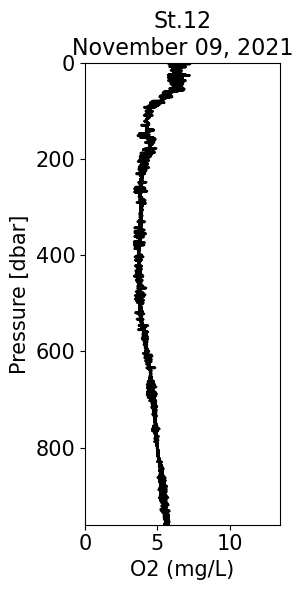

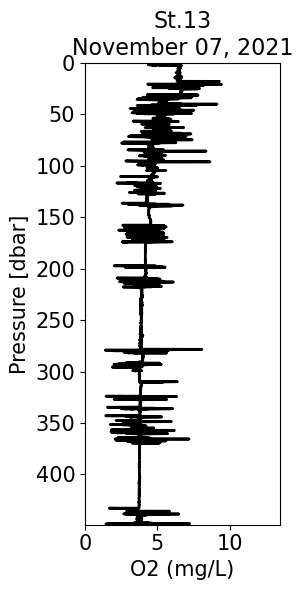

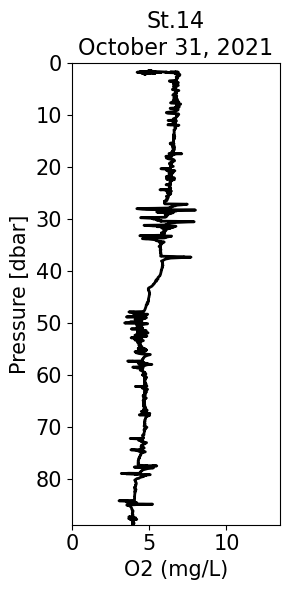

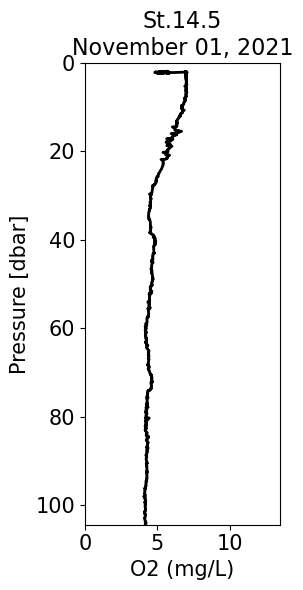

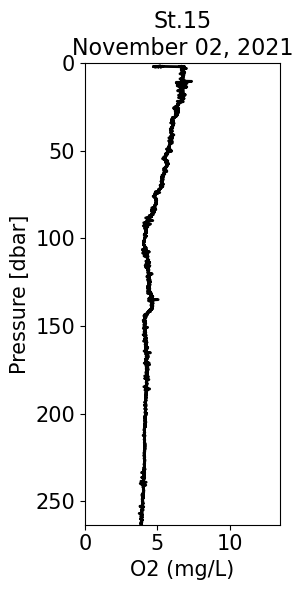

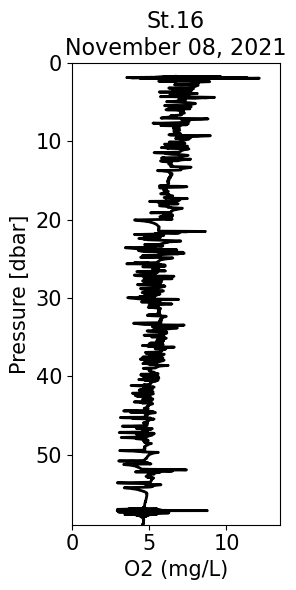

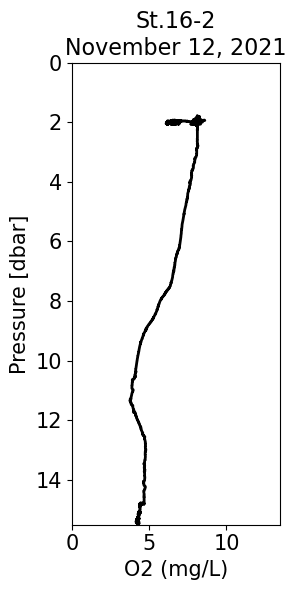

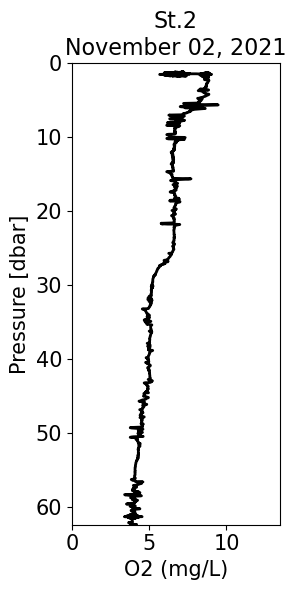

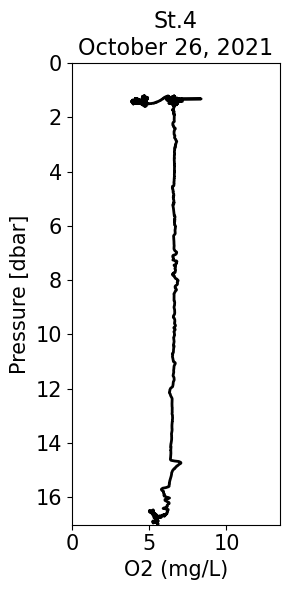

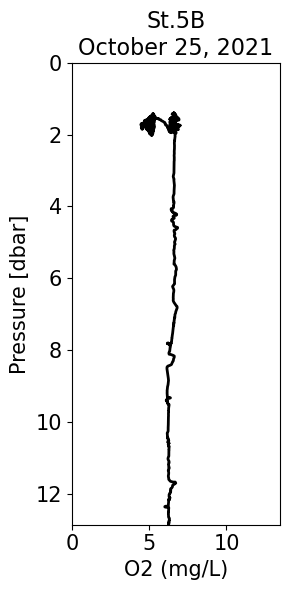

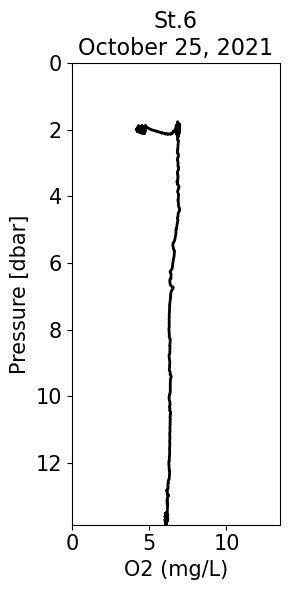

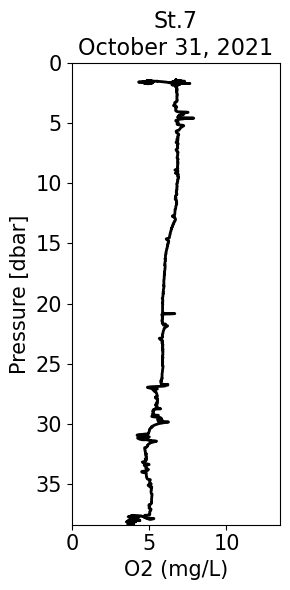

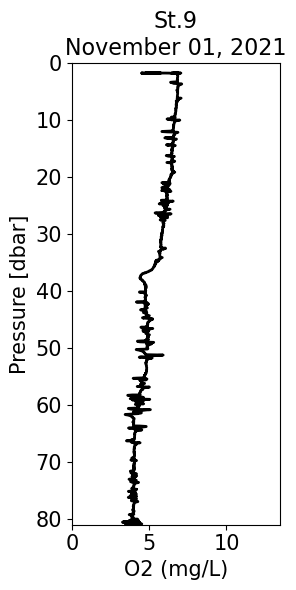

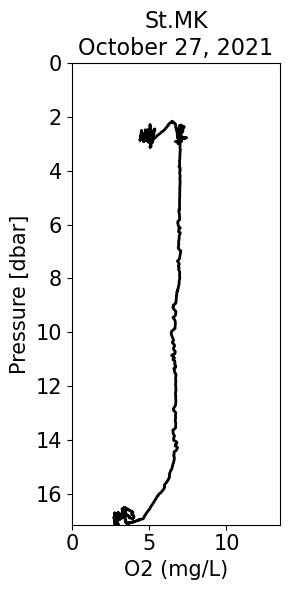

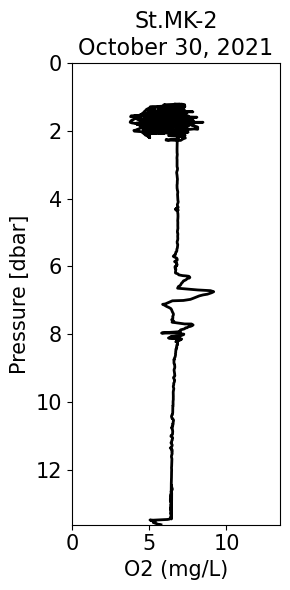

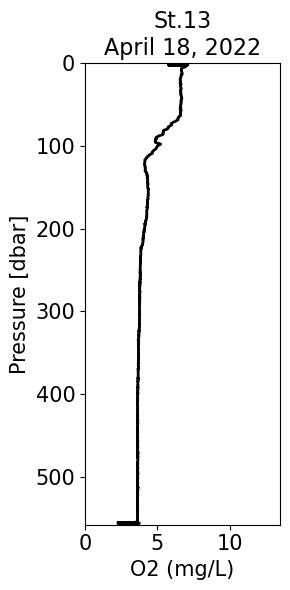

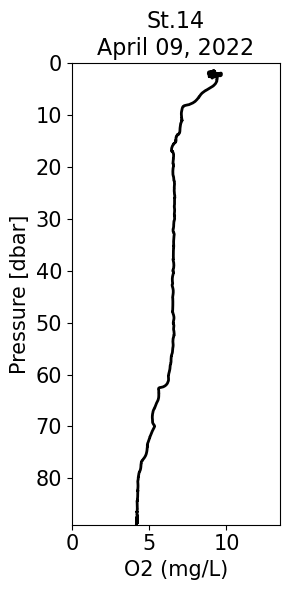

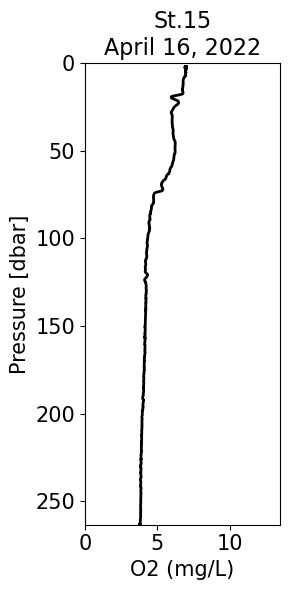

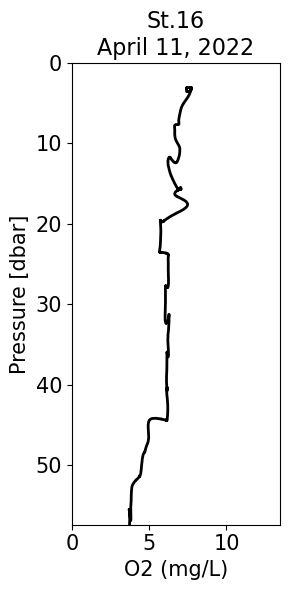

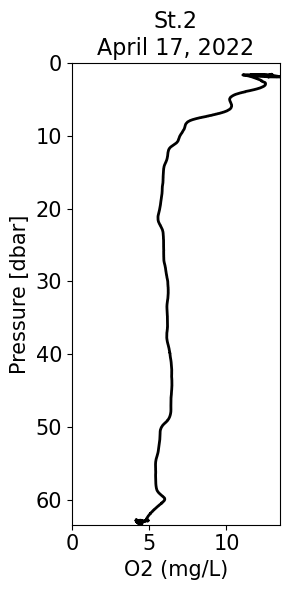

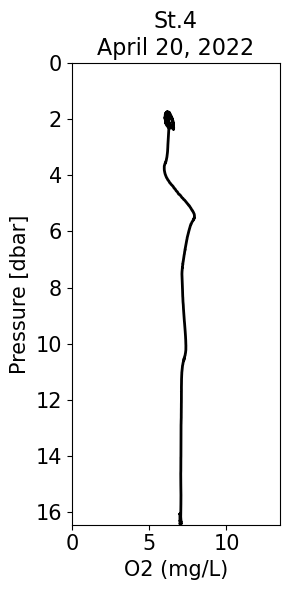

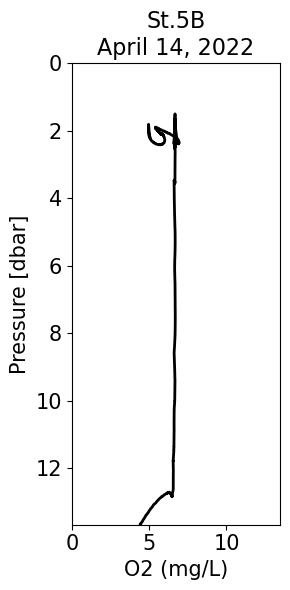

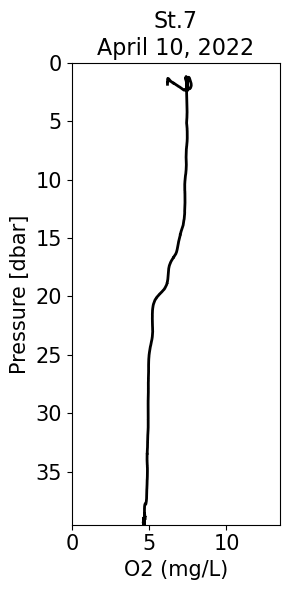

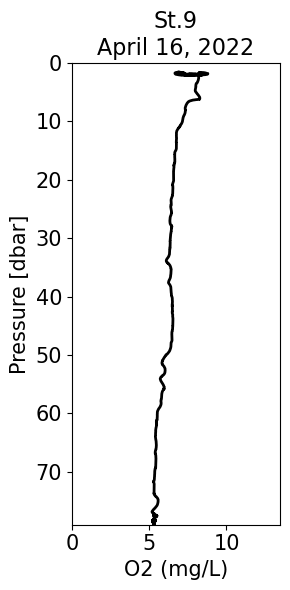

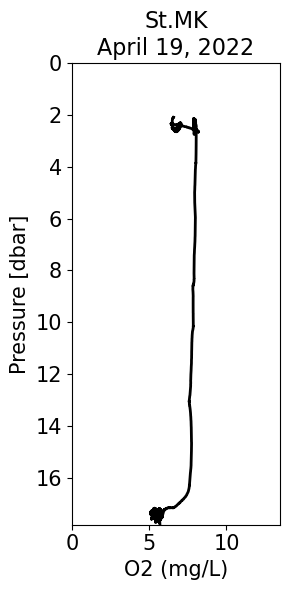

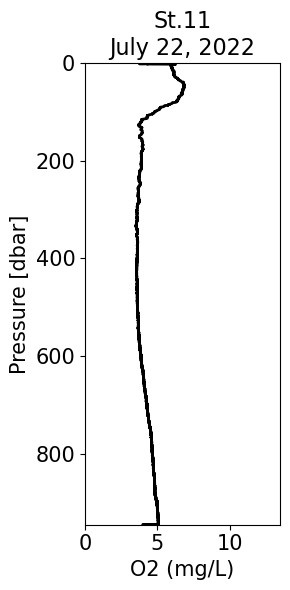

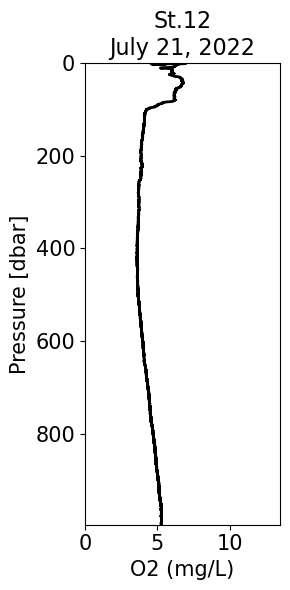

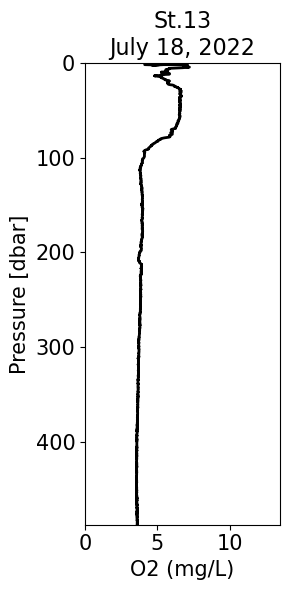

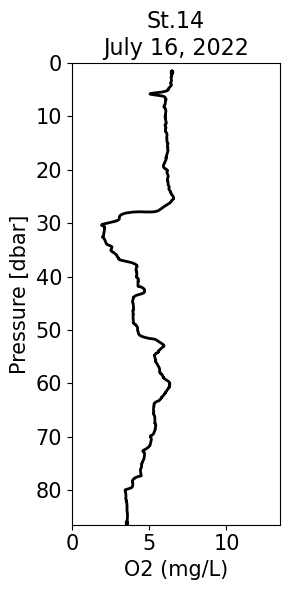

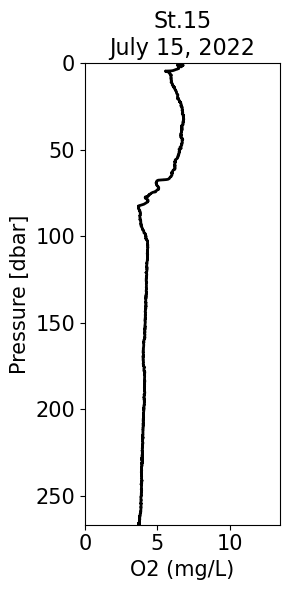

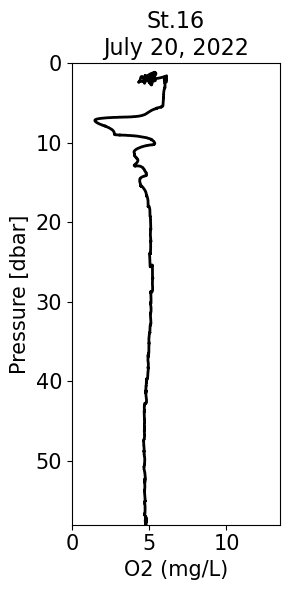

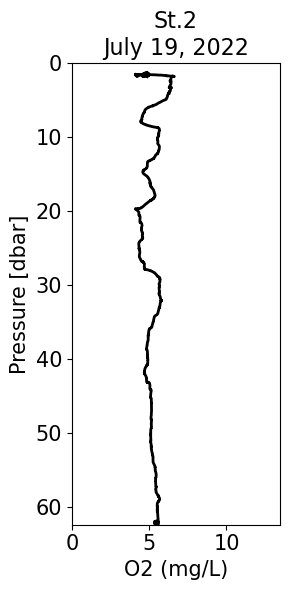

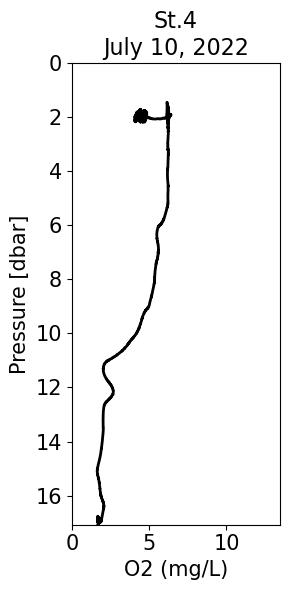

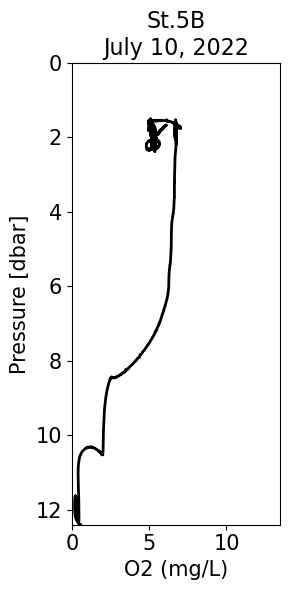

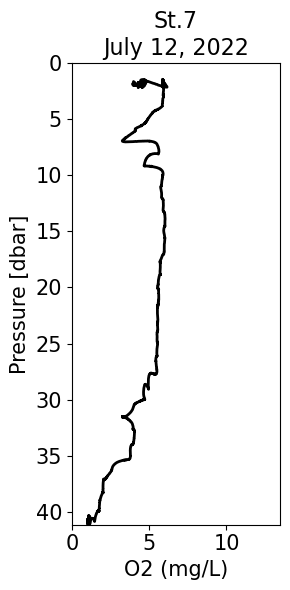

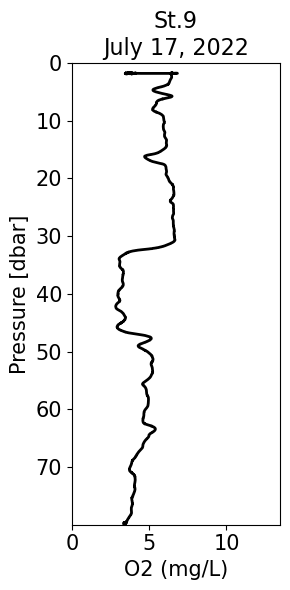

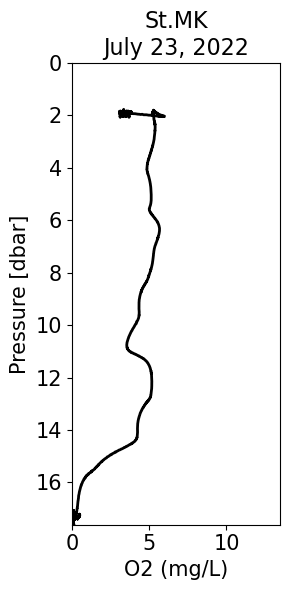

In [6]:
# Reset index of ds_ctd
ds_ctd = ds_ctd.reset_index(drop=True)

# Group by 'camp' and 'station'
grouped = ds_ctd.groupby(['camp', 'station'])

# Loop through each group to create plots
for (camp, station), group in grouped:
    plt.figure(figsize=(3, 6))
    
    # Plot the data
    plt.plot(group['sbeox0Mg/L'], group['Pressure [dbar]'], color='black', linewidth=2)
    
    # Set axis limits and labels
    plt.xlim(0, ds_ctd['sbeox0Mg/L'].max())
    plt.ylim(group['maxd'].max(), 0)  # inverting y-axis as pressure increases downwards
    plt.xlabel('O2 (mg/L)', size = 15)
    plt.ylabel('Pressure [dbar]', size = 15)
    plt.title(station + "\n" + pd.to_datetime(group['dates'].iloc[0]).strftime('%B %d, %Y'), size = 16)
    
    # Update tick parameters
    plt.gca().tick_params(axis='both', colors='black', labelsize=15)
    
    # Save the figure
    plt.tight_layout()
    plt.savefig('../Dissertation_projects/Figures/CTD_profiles/O2_profiles/' + f"{camp}_{station}_O2_profile.png")
    
    # Show the figure
    plt.show()


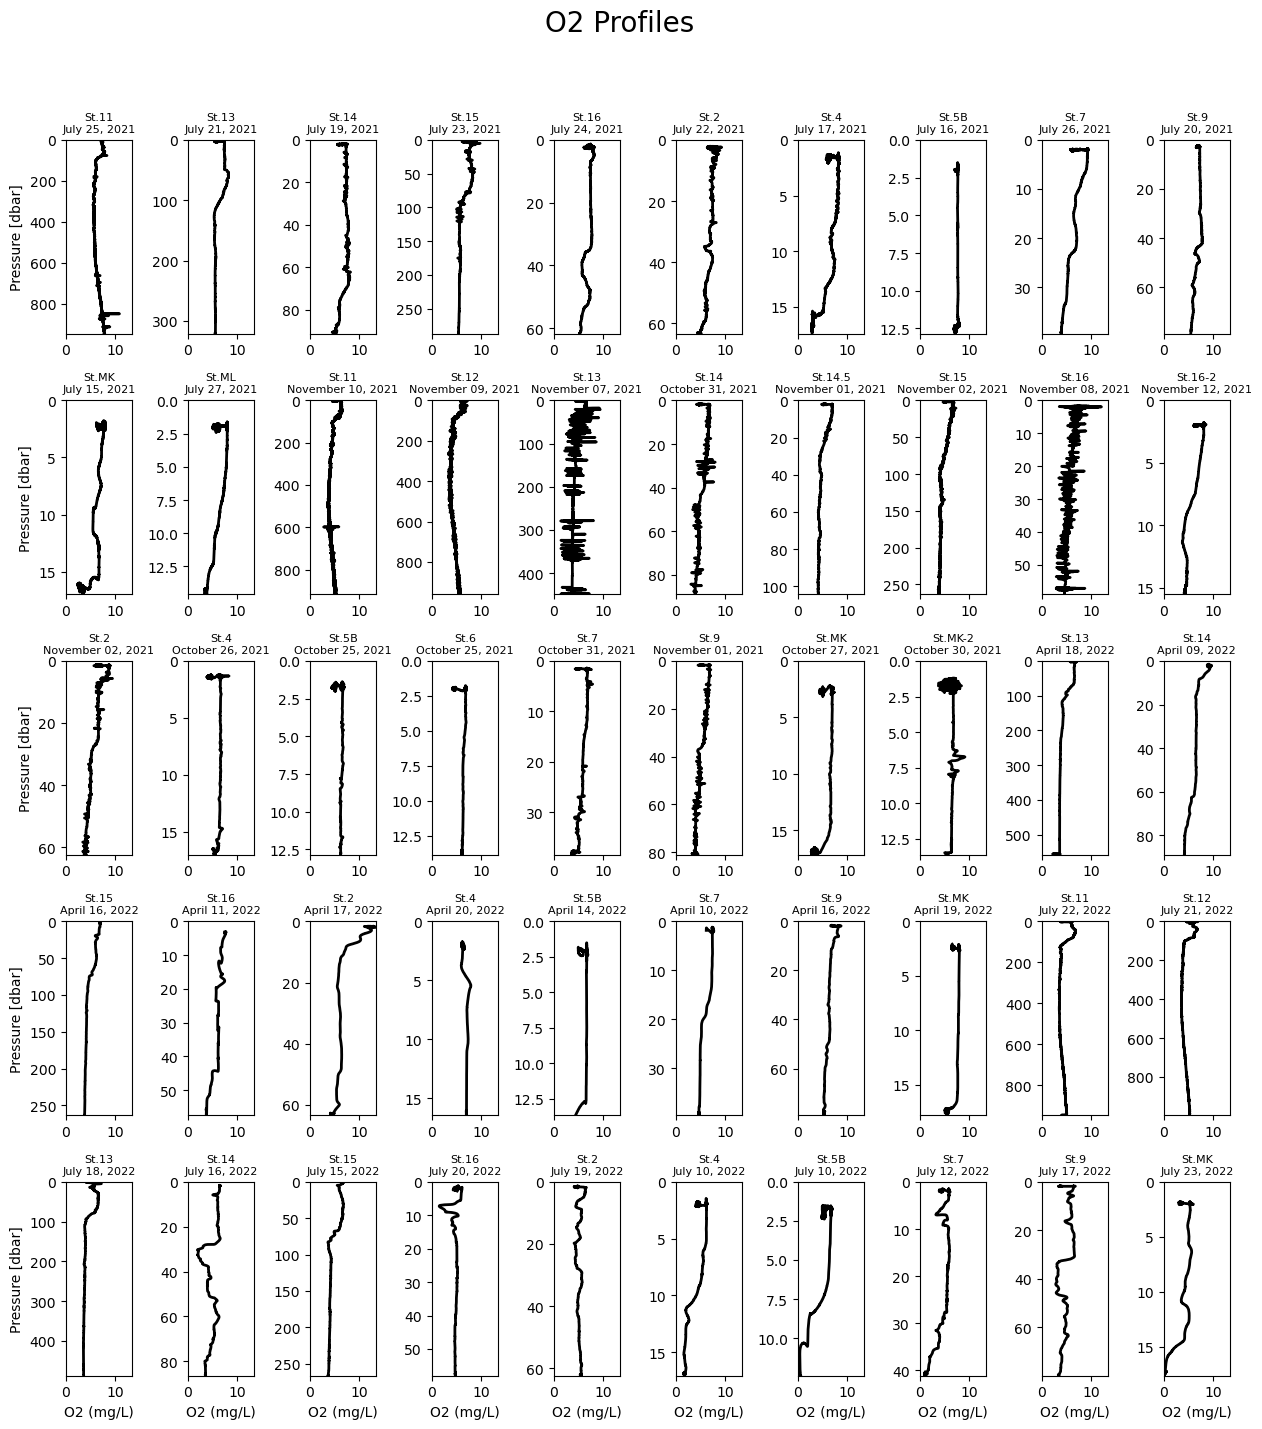

In [7]:
# Reset index of ds_ctd
ds_ctd = ds_ctd.reset_index(drop=True)

# Group by 'camp' and 'station'
grouped = ds_ctd.groupby(['camp', 'station'])

# Number of unique groups
n_groups = len(grouped)

# Calculate the grid dimensions
n_cols = 10
n_rows = -(-n_groups // n_cols)  # Ceiling division

# Create a grid of subplots without sharing x and y
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*1.25, n_rows*3))
fig.suptitle('O2 Profiles', fontsize=20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Flattening the axes for easy indexing
if axes.ndim > 1:
    axes = axes.ravel()

# Iterate through the groups and plot data on respective subplots
for idx, ((camp, station), group) in enumerate(grouped):
    ax = axes[idx]
    
    # Plot data
    ax.plot(group['sbeox0Mg/L'], group['Pressure [dbar]'], color='black', linewidth=2)
    
    # Set individual x and y limits for each subplot
    ax.set_xlim(0, ds_ctd['sbeox0Mg/L'].max())
    ax.set_ylim(group['Pressure [dbar]'].max(), 0)  # inverted y-axis
    
    # Set title for the subplot
    ax.set_title(station + "\n" + pd.to_datetime(group['dates'].iloc[0]).strftime('%B %d, %Y'), fontsize=8)
    
    # Update tick parameters
    ax.tick_params(axis='both', colors='black', labelsize=10)

    # Set x and y labels for subplots on the edges of the grid
    if idx // n_cols == n_rows - 1:  # bottom-most plots
        ax.set_xlabel('O2 (mg/L)', fontsize=10)
    if idx % n_cols == 0:  # left-most plots
        ax.set_ylabel('Pressure [dbar]', fontsize=10)

# Save the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to account for the title
plt.savefig('../Dissertation_projects/Figures/CTD_profiles/O2_profiles/O2_profiles_grid.png')

# Show the figure
plt.show()


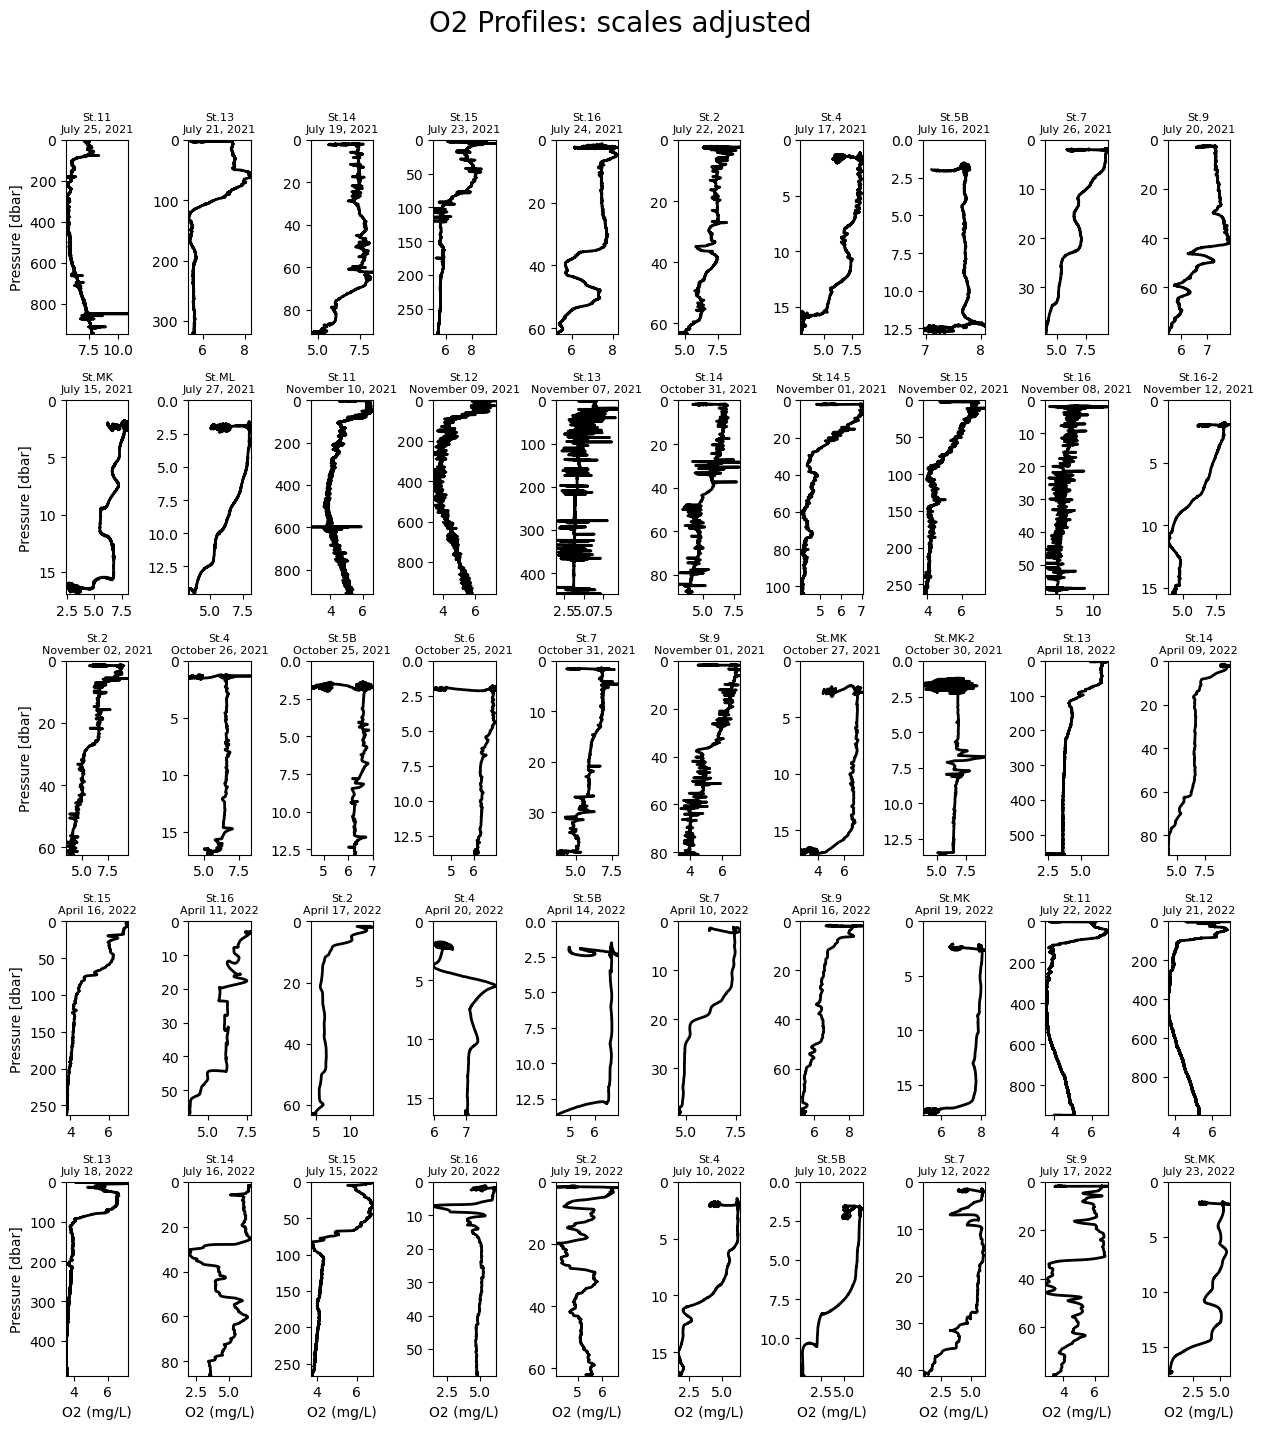

In [8]:
# Reset index of ds_ctd
ds_ctd = ds_ctd.reset_index(drop=True)

# Group by 'camp' and 'station'
grouped = ds_ctd.groupby(['camp', 'station'])

# Number of unique groups
n_groups = len(grouped)

# Calculate the grid dimensions
n_cols = 10
n_rows = -(-n_groups // n_cols)  # Ceiling division

# Create a grid of subplots without sharing x and y
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*1.25, n_rows*3))
fig.suptitle('O2 Profiles: scales adjusted', fontsize=20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Flattening the axes for easy indexing
if axes.ndim > 1:
    axes = axes.ravel()

# Iterate through the groups and plot data on respective subplots
for idx, ((camp, station), group) in enumerate(grouped):
    ax = axes[idx]
    
    # Plot data
    ax.plot(group['sbeox0Mg/L'], group['Pressure [dbar]'], color='black', linewidth=2)
    
    # Set individual x and y limits for each subplot
    ax.set_xlim(group['sbeox0Mg/L'].min(), group['sbeox0Mg/L'].max())
    ax.set_ylim(group['Pressure [dbar]'].max(), 0)  # inverted y-axis
    
    # Set title for the subplot
    ax.set_title(station + "\n" + pd.to_datetime(group['dates'].iloc[0]).strftime('%B %d, %Y'), fontsize=8)
    
    # Update tick parameters
    ax.tick_params(axis='both', colors='black', labelsize=10)

    # Set x and y labels for subplots on the edges of the grid
    if idx // n_cols == n_rows - 1:  # bottom-most plots
        ax.set_xlabel('O2 (mg/L)', fontsize=10)
    if idx % n_cols == 0:  # left-most plots
        ax.set_ylabel('Pressure [dbar]', fontsize=10)

# Save the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to account for the title
plt.savefig('../Dissertation_projects/Figures/CTD_profiles/O2_profiles/O2_profiles_grid_scaled.png')

# Show the figure
plt.show()


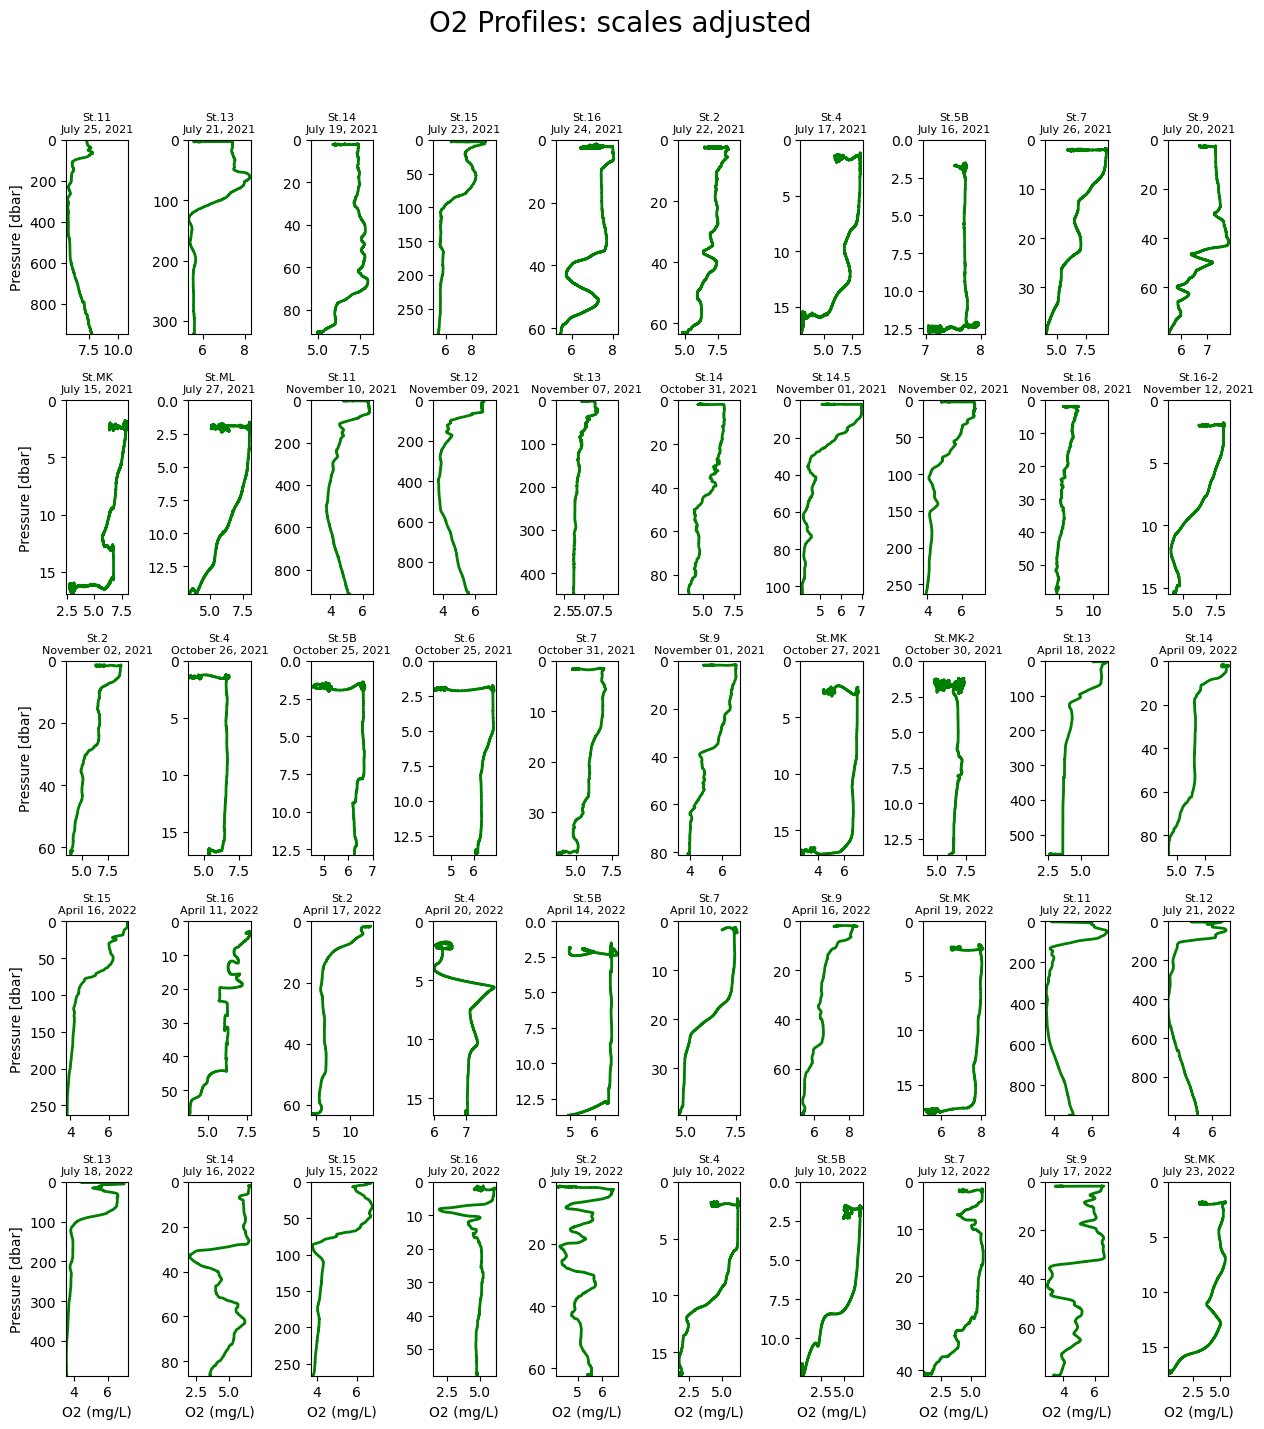

In [22]:
# Reset index of ds_ctd
ds_ctd = ds_ctd.reset_index(drop=True)

# Group by 'camp' and 'station'
grouped = ds_ctd.groupby(['camp', 'station'])

# Number of unique groups
n_groups = len(grouped)

# Calculate the grid dimensions
n_cols = 10
n_rows = -(-n_groups // n_cols)  # Ceiling division

# Create a grid of subplots without sharing x and y
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*1.25, n_rows*3))
fig.suptitle('O2 Profiles: scales adjusted', fontsize=20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Flattening the axes for easy indexing
if axes.ndim > 1:
    axes = axes.ravel()

# Moving average function
def moving_average(data, window_size=5):
    """Calculate moving average with specified window size."""
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

# Iterate through the groups and plot data on respective subplots
for idx, ((camp, station), group) in enumerate(grouped):
    ax = axes[idx]
    
    window = round(len(group['sbeox0Mg/L'])/50)
    
    # Plot original data
    #ax.plot(group['sbeox0Mg/L'], group['Pressure [dbar]'], color='black', linewidth=2)

    # Calculate smoothed data and plot
    smoothed_data = moving_average(group['sbeox0Mg/L'].values, window)
    ax.plot(smoothed_data, group['Pressure [dbar]'].values[window-1:], color='green', linewidth=2)  # Note the slicing to align the data after smoothing
    
    # Set individual x and y limits for each subplot
    ax.set_xlim(group['sbeox0Mg/L'].min(), group['sbeox0Mg/L'].max())
    ax.set_ylim(group['Pressure [dbar]'].max(), 0)  # inverted y-axis
    
    # Set title for the subplot
    ax.set_title(station + "\n" + pd.to_datetime(group['dates'].iloc[0]).strftime('%B %d, %Y'), fontsize=8)
    
    # Update tick parameters
    ax.tick_params(axis='both', colors='black', labelsize=10)

    # Set x and y labels for subplots on the edges of the grid
    if idx // n_cols == n_rows - 1:  # bottom-most plots
        ax.set_xlabel('O2 (mg/L)', fontsize=10)
    if idx % n_cols == 0:  # left-most plots
        ax.set_ylabel('Pressure [dbar]', fontsize=10)

# Save the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to account for the title
plt.savefig('../Dissertation_projects/Figures/CTD_profiles/O2_profiles/O2_profiles_smoothed.png')

# Show the figure
plt.show()


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning: invalid value encountered in divide
  c = d

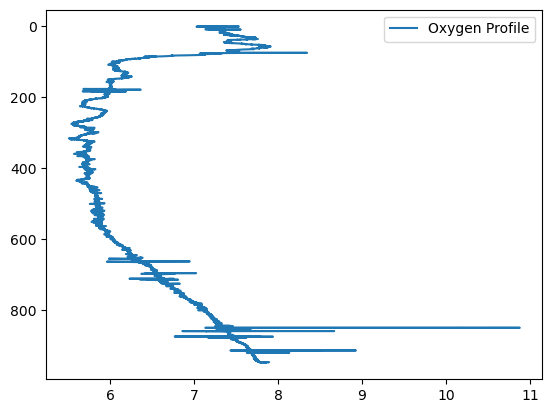

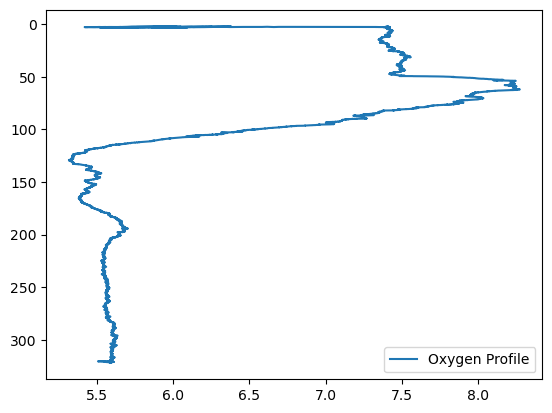

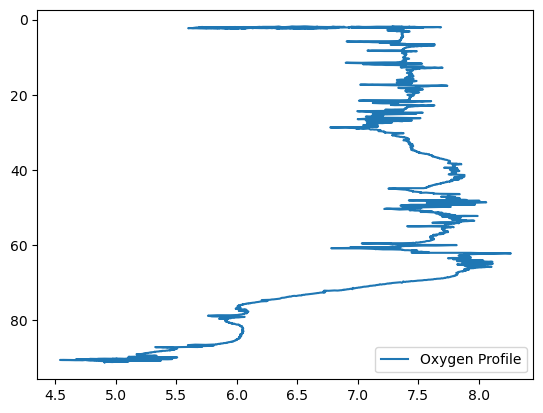

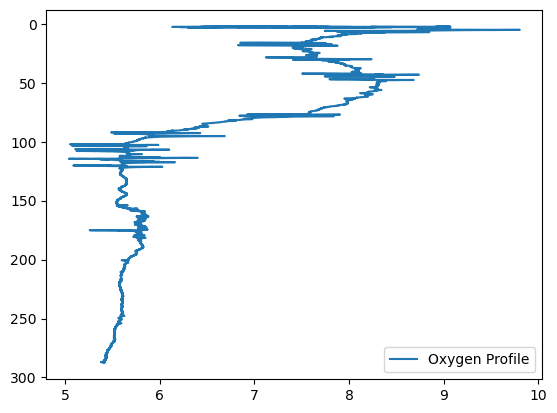

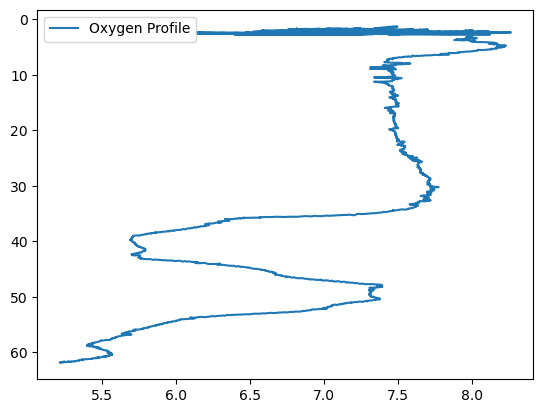

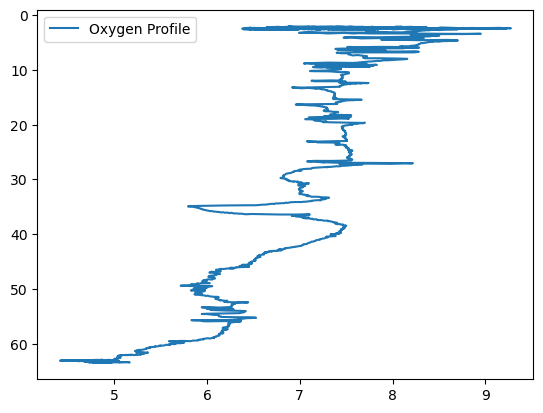

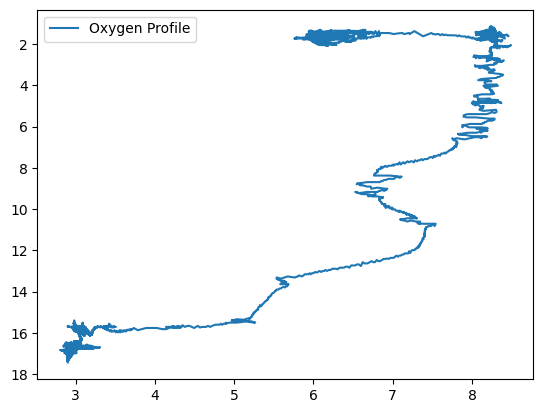

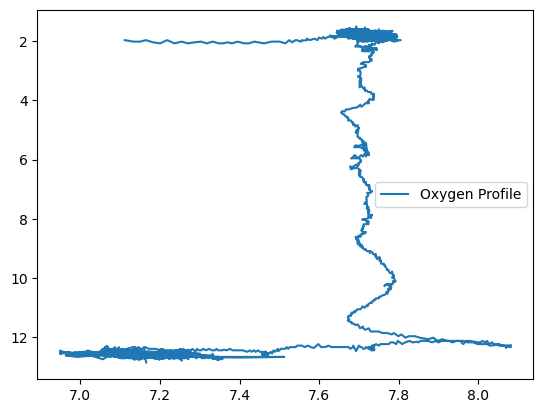

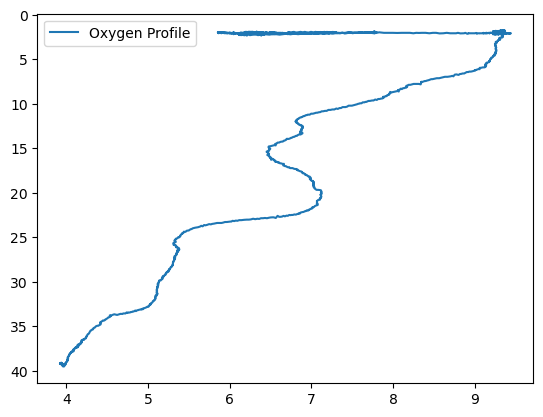

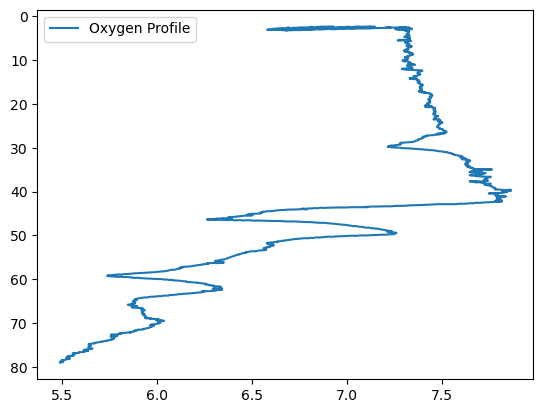

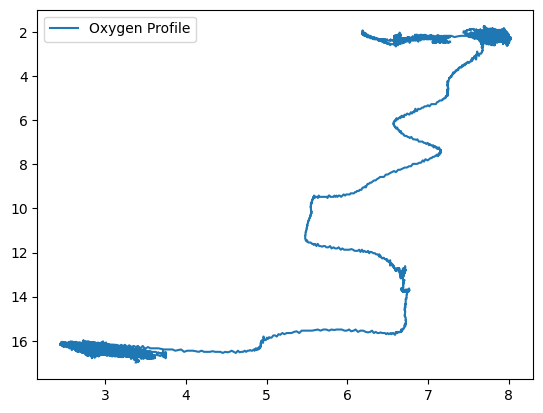

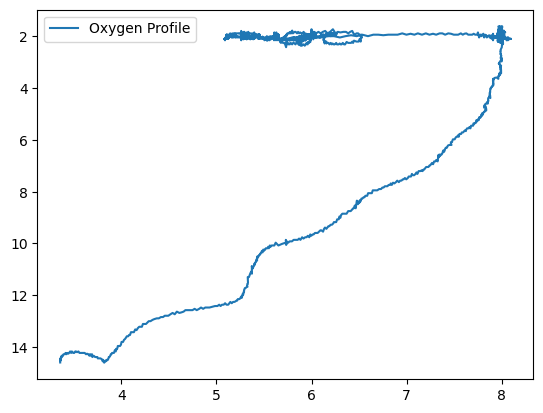

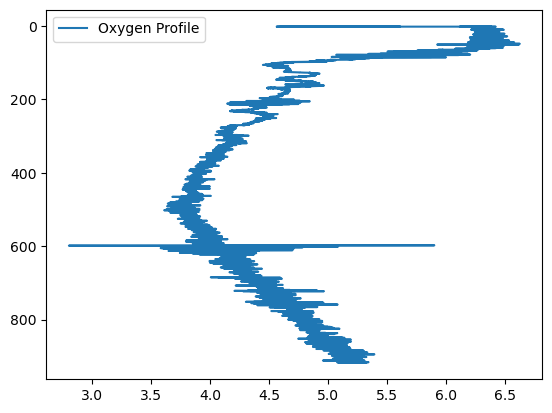

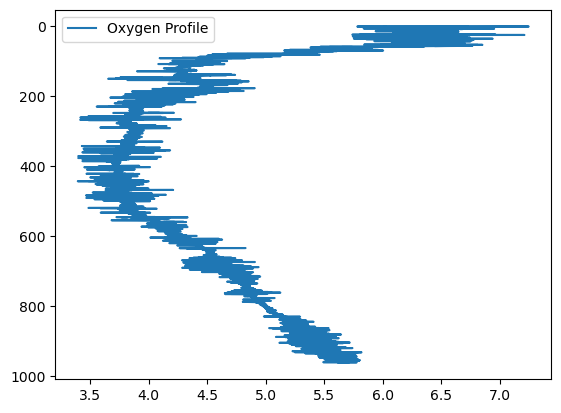

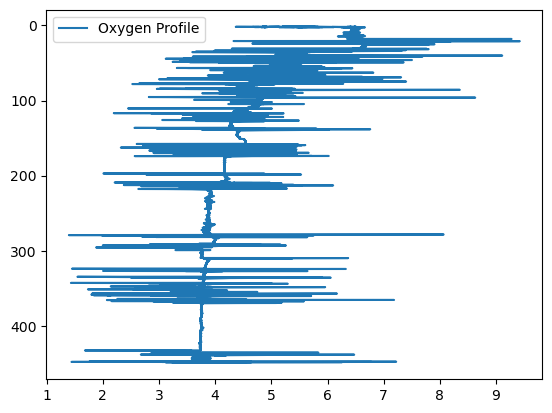

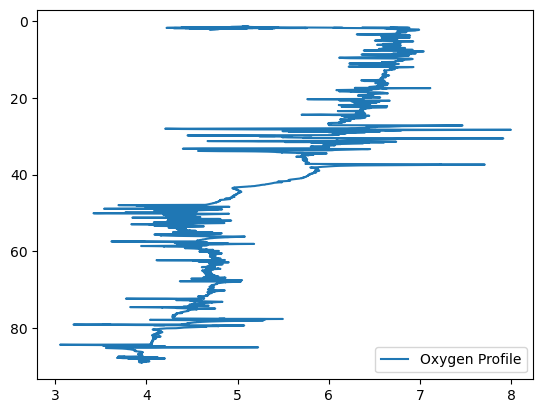

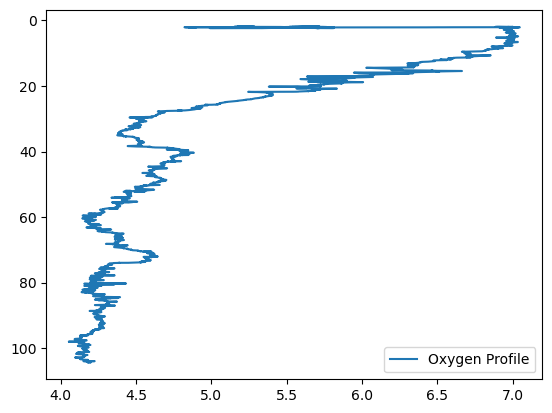

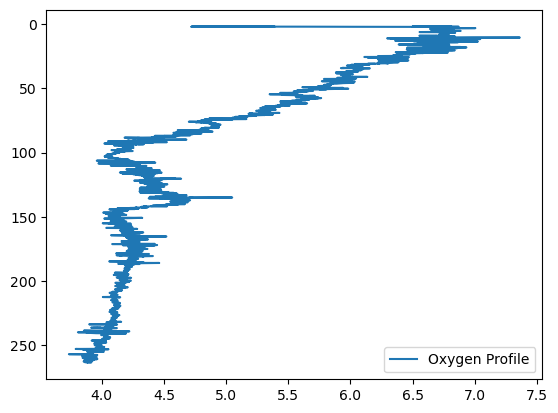

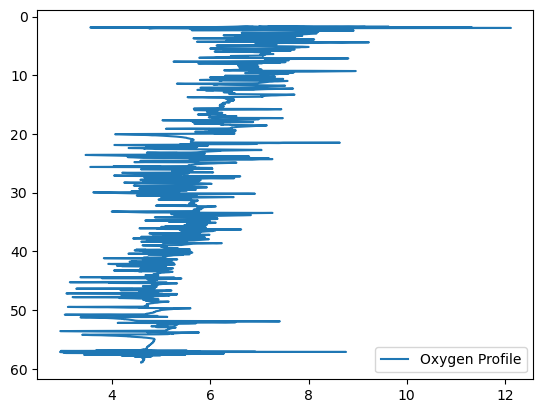

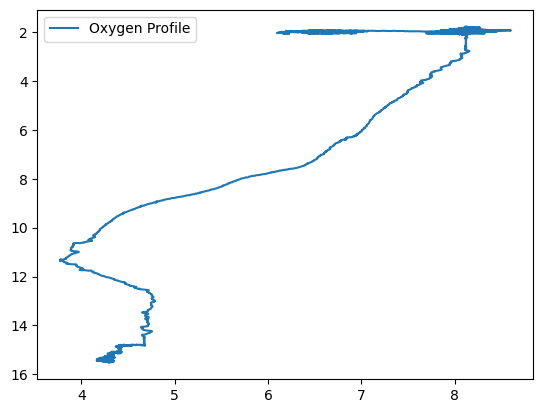

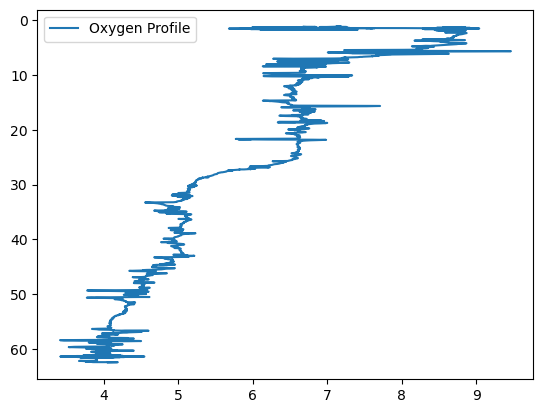

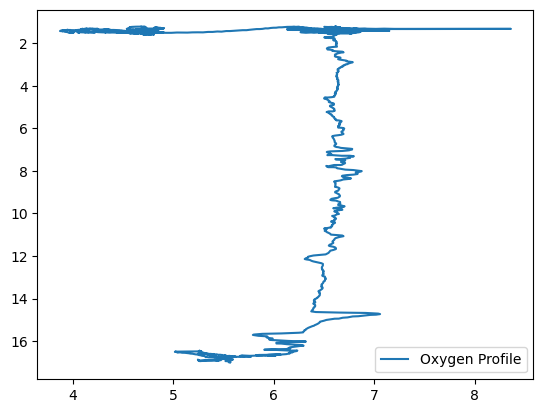

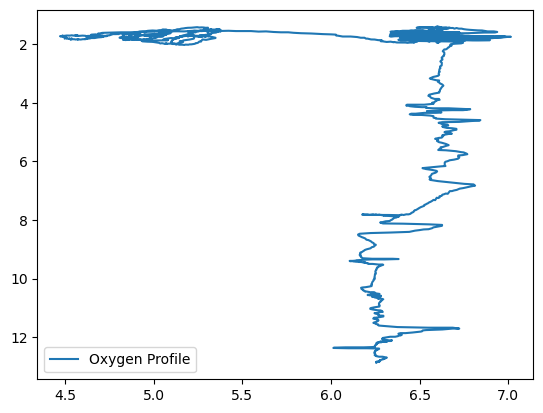

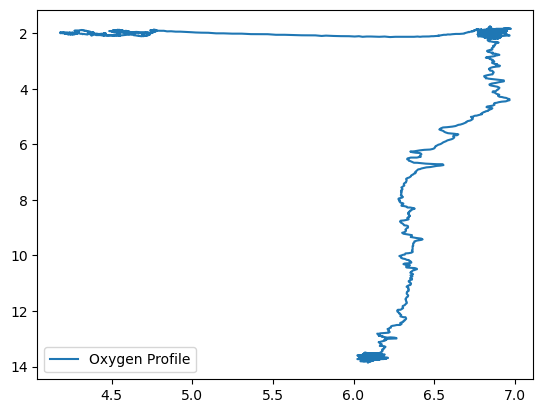

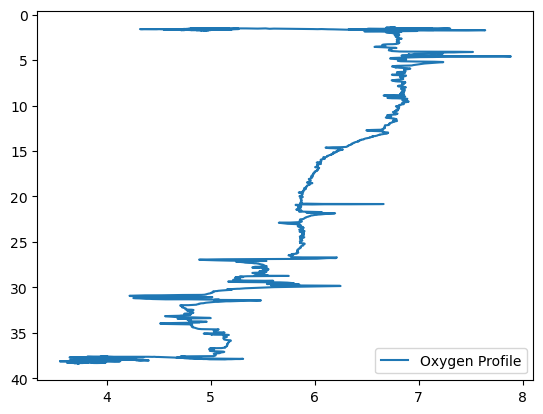

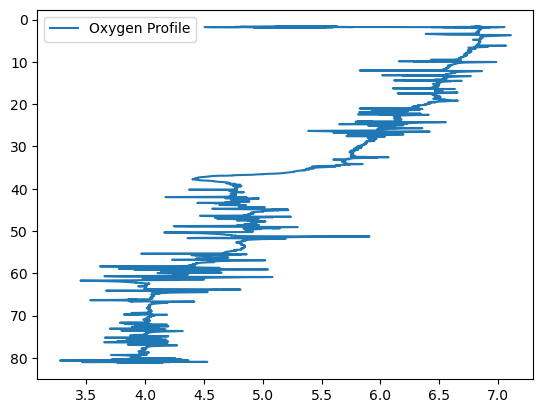

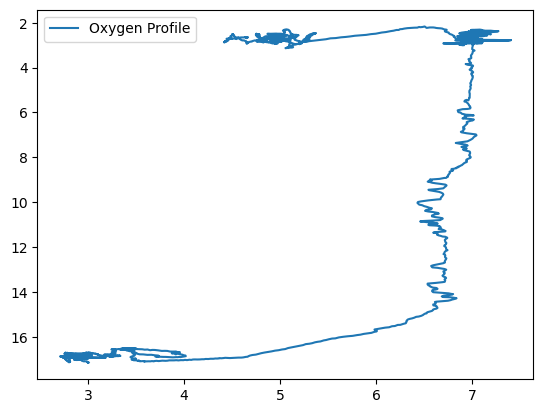

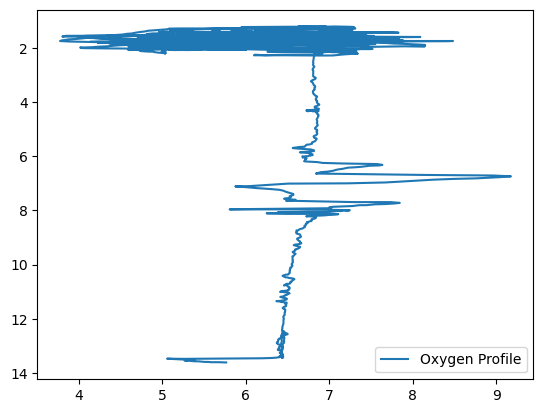

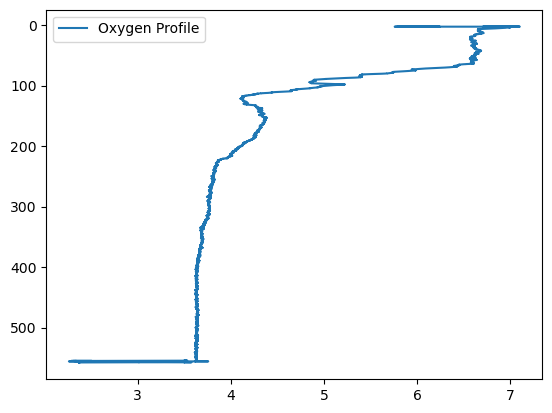

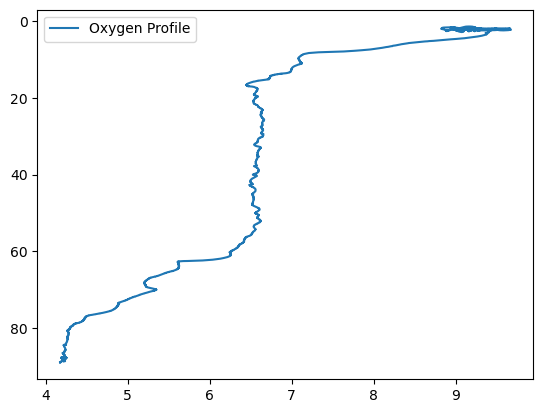

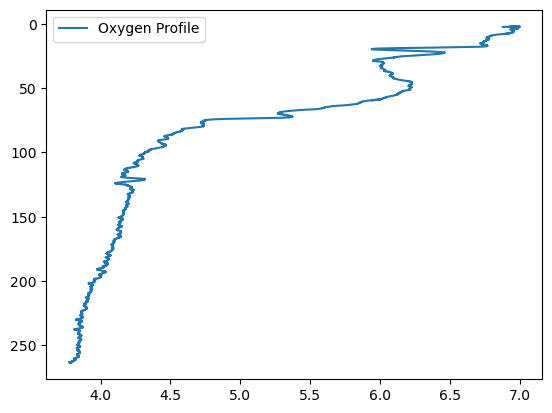

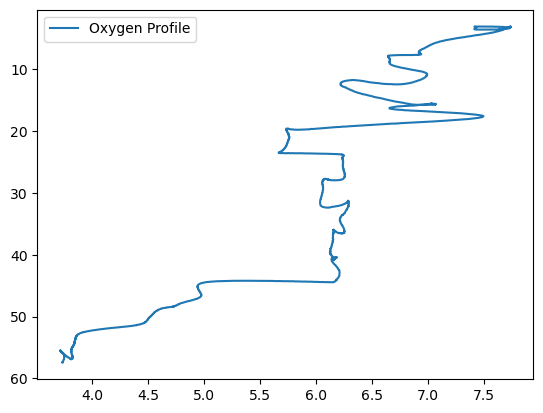

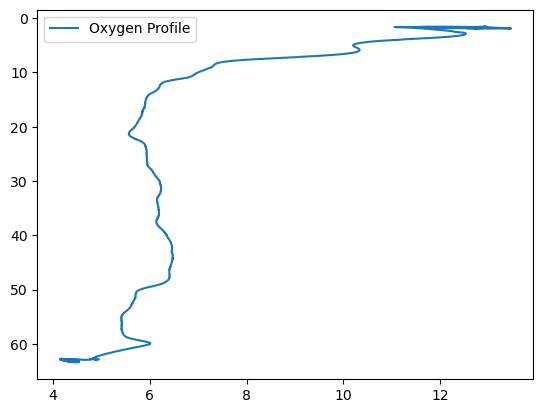

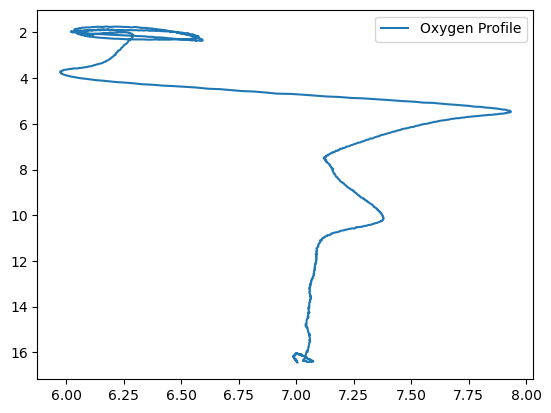

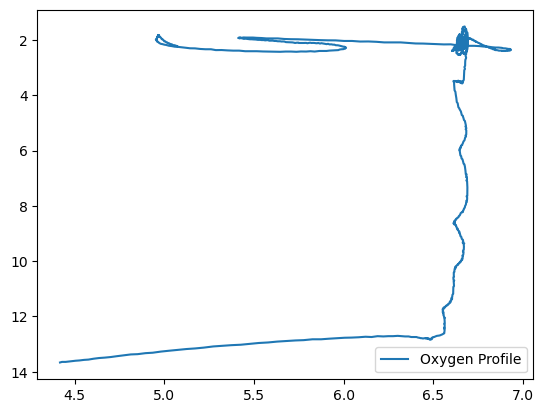

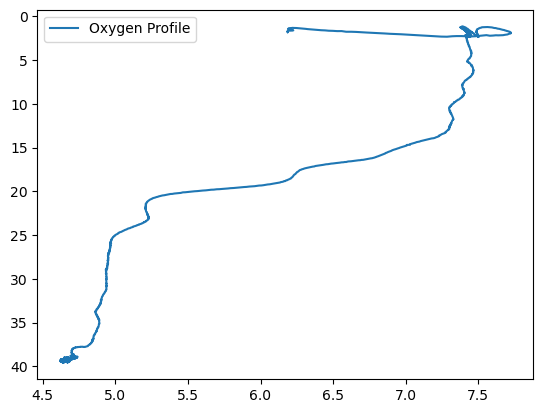

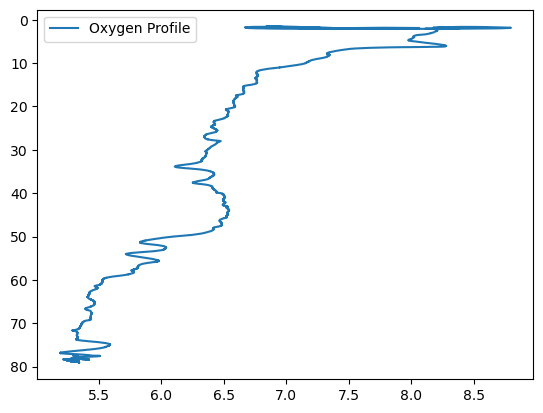

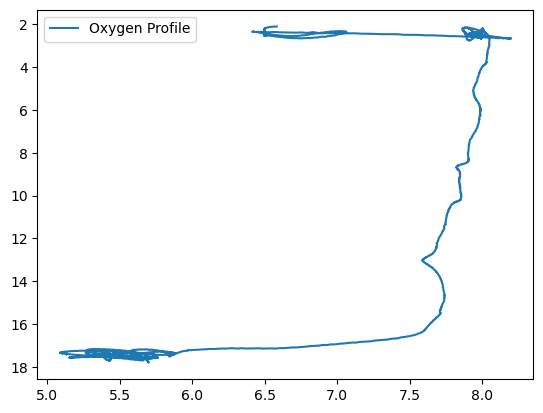

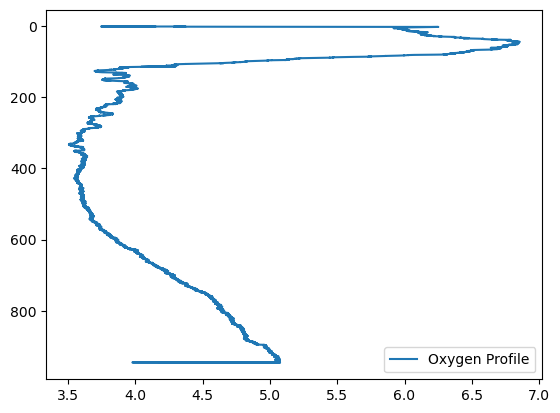

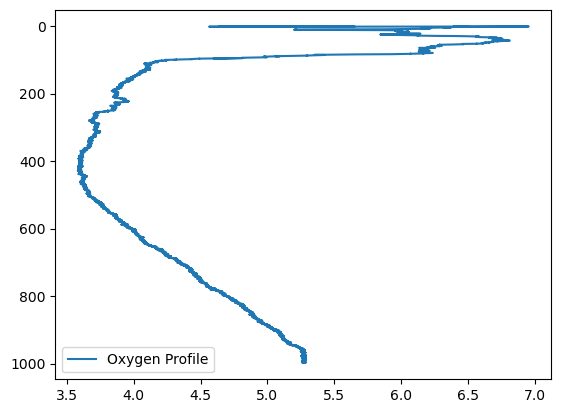

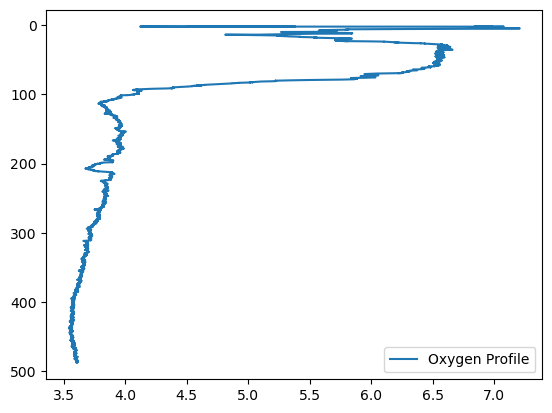

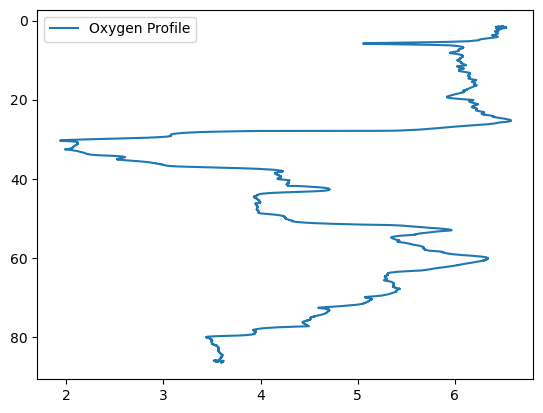

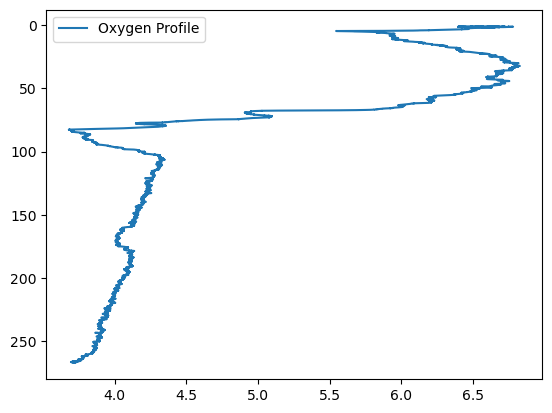

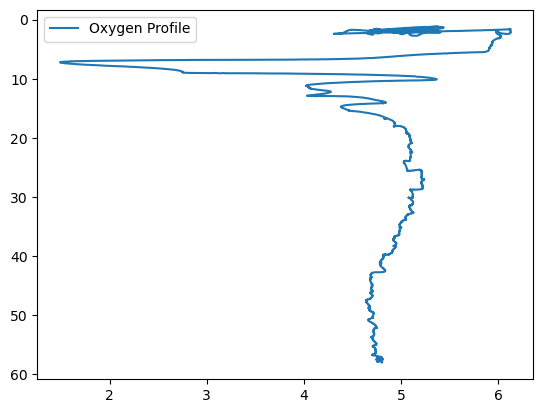

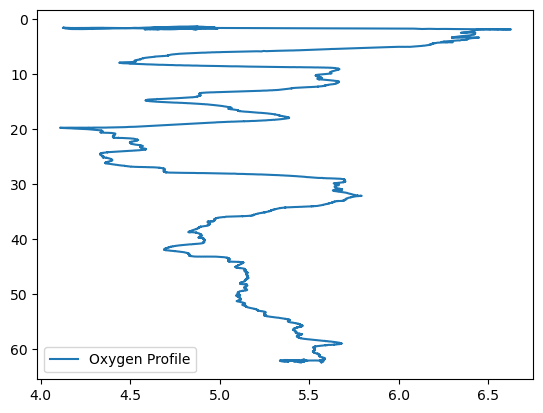

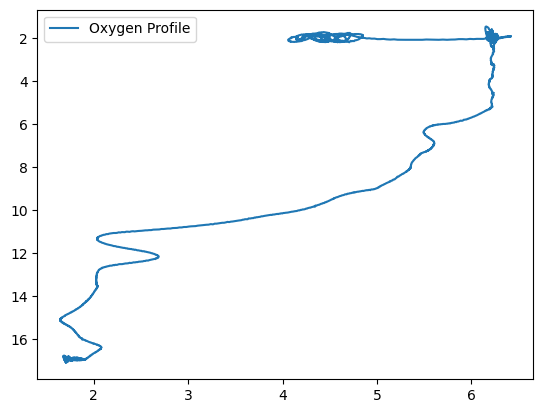

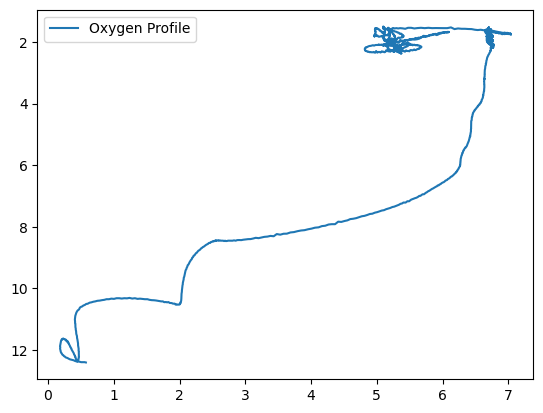

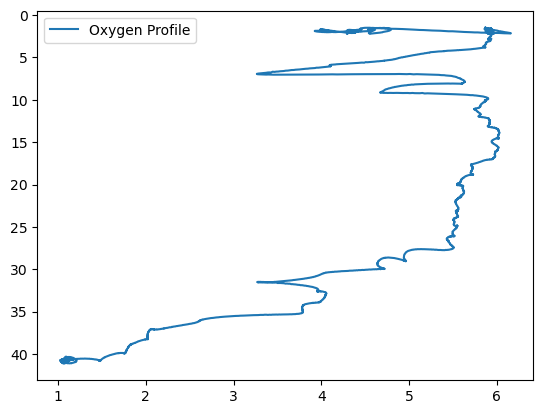

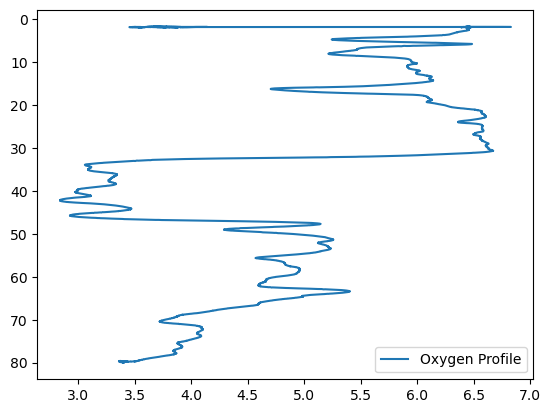

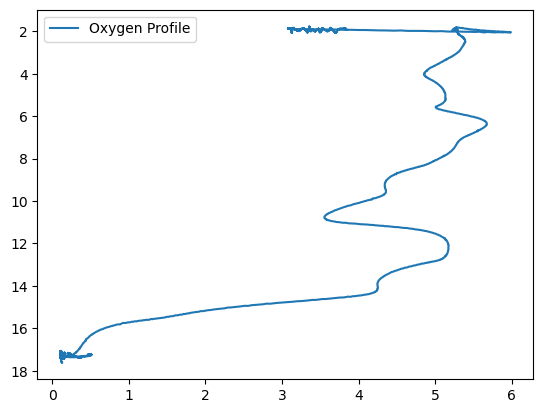

In [24]:
#Reset index of ds_ctd
ds_ctd = ds_ctd.reset_index(drop=True)

# Group by 'camp' and 'station'
grouped = ds_ctd.groupby(['camp', 'station'])

# Number of unique groups
n_groups = len(grouped)

# Calculate the grid dimensions
n_cols = 10
n_rows = -(-n_groups // n_cols)  # Ceiling division

# Reset index of ds_ctd
ds_ctd = ds_ctd.reset_index(drop=True)

# Group by 'camp' and 'station'
grouped = ds_ctd.groupby(['camp', 'station'])

# Number of unique groups
n_groups = len(grouped)

# Calculate the grid dimensions
n_cols = 10
n_rows = -(-n_groups // n_cols)  # Ceiling division

for idx, ((camp, station), group) in enumerate(grouped):
    #Assuming `depths` and `oxygen` are 1D numpy arrays for a single station/profile
    oxygen = group['sbeox0Mg/L'].ravel()
    depths = group['Pressure [dbar]'].ravel()
    
    derivatives = np.gradient(oxygen, depths)

    # Hypoxia threshold and derivative threshold (change as needed)
    hypoxia_thresh = 2.0
    deriv_thresh = 0.2  # arbitrary, adjust based on your dataset

    hypoxic_regions = np.where(oxygen < hypoxia_thresh)[0]
    significant_slopes = np.where(derivatives > deriv_thresh)[0]

    # Identify start of slope regions
    slope_starts = [idx for idx in hypoxic_regions if idx in significant_slopes]

    # Visualization

    plt.plot(oxygen, depths, label='Oxygen Profile')
    for start in slope_starts:
        end = start + 1  # this assumes slope region is continuous, adjust as needed
        slope, intercept, _, _, _ = linregress(depths[start:end], oxygen[start:end])
        plt.plot(depths[start:end], slope*depths[start:end] + intercept, label=f'Slope from {start}')

    plt.gca().invert_yaxis()  # since depth typically increases downwards
    plt.legend()
    plt.show()


C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning: invalid value encountered in divide
  c = d

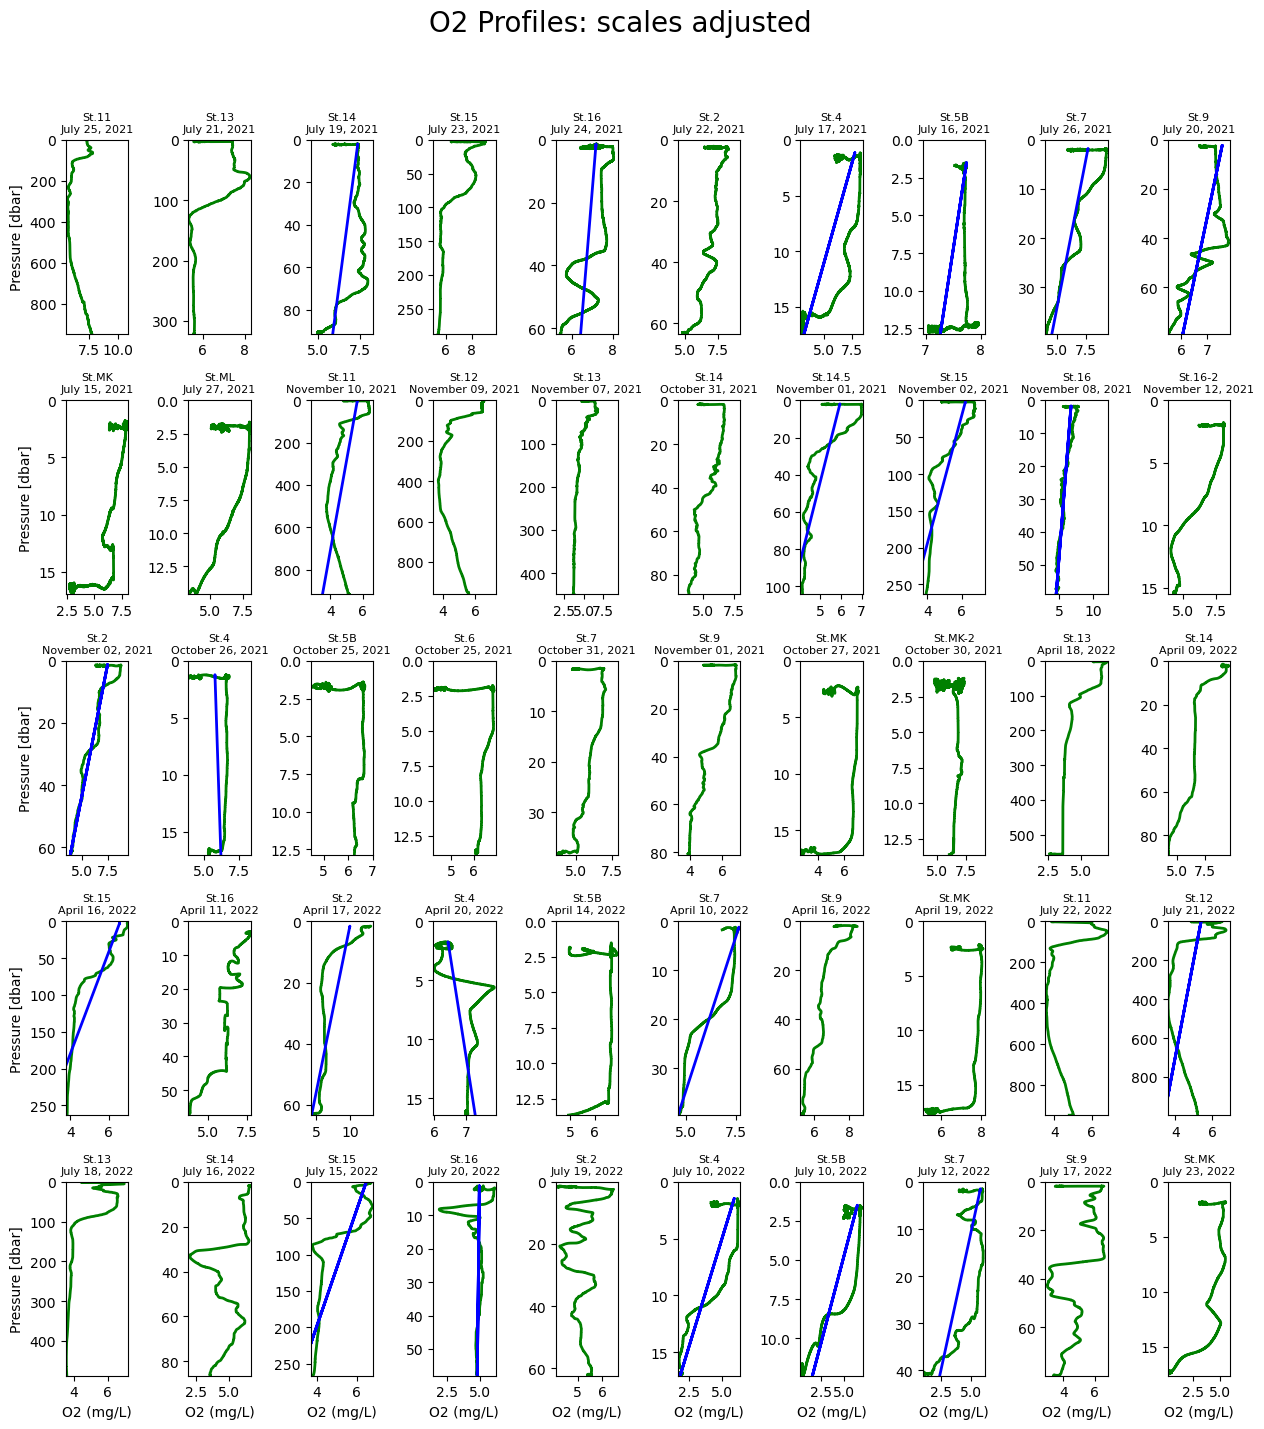

In [26]:
# Reset index of ds_ctd
ds_ctd = ds_ctd.reset_index(drop=True)

# Group by 'camp' and 'station'
grouped = ds_ctd.groupby(['camp', 'station'])

# Number of unique groups
n_groups = len(grouped)

# Calculate the grid dimensions
n_cols = 10
n_rows = -(-n_groups // n_cols)  # Ceiling division

# Create a grid of subplots without sharing x and y
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*1.25, n_rows*3))
fig.suptitle('O2 Profiles: scales adjusted', fontsize=20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Flattening the axes for easy indexing
if axes.ndim > 1:
    axes = axes.ravel()

# Moving average function
def moving_average(data, window_size=5):
    """Calculate moving average with specified window size."""
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

# Calculate the derivative
def calculate_derivative(data, depths):
    return np.gradient(data, depths)

# Find the start of hypoxia slopes based on derivative values
def find_slope_start(derivatives, threshold=0.2):  # threshold is arbitrary, adjust based on your data
    candidates = np.where(derivatives > threshold)[0]
    if len(candidates) > 0:
        return candidates[0]
    else:
        return None

# Iterate through the groups and plot data on respective subplots
for idx, ((camp, station), group) in enumerate(grouped):
    ax = axes[idx]
    
    window = round(len(group['sbeox0Mg/L'])/50)
    
    # Calculate smoothed data
    smoothed_data = moving_average(group['sbeox0Mg/L'].values, window)
    smoothed_depths = group['Pressure [dbar]'].values[window-1:]
    
    # Ensure they have the same size
    if len(smoothed_data) == len(smoothed_depths):
        ax.plot(smoothed_data, smoothed_depths, color='green', linewidth=2)
    else:
        continue  # Skip this iteration and don't plot
    
    # Calculate derivatives for the smoothed data
    derivatives = calculate_derivative(smoothed_data, smoothed_depths)
    slope_start_idx = find_slope_start(derivatives)

    # If a slope start is identified, perform linear regression and plot
    if slope_start_idx is not None and slope_start_idx < len(smoothed_data) and slope_start_idx < len(smoothed_depths):
        slope, intercept, _, _, _ = linregress(smoothed_depths[slope_start_idx:], smoothed_data[slope_start_idx:])
        ax.plot(slope*smoothed_depths[slope_start_idx:] + intercept, smoothed_depths[slope_start_idx:], color='blue', linewidth=2)

    # Setting limits and titles for subplots
    ax.set_xlim(group['sbeox0Mg/L'].min(), group['sbeox0Mg/L'].max())
    ax.set_ylim(group['Pressure [dbar]'].max(), 0)  # inverted y-axis
    ax.set_title(station + "\n" + pd.to_datetime(group['dates'].iloc[0]).strftime('%B %d, %Y'), fontsize=8)
    ax.tick_params(axis='both', colors='black', labelsize=10)

    # Set x and y labels for subplots on the edges of the grid
    if idx // n_cols == n_rows - 1:  # bottom-most plots
        ax.set_xlabel('O2 (mg/L)', fontsize=10)
    if idx % n_cols == 0:  # left-most plots
        ax.set_ylabel('Pressure [dbar]', fontsize=10)

# Save and show the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to account for the title
#plt.savefig('../Dissertation_projects/Figures/CTD_profiles/O2_profiles/O2_profiles_smoothed.png')
plt.show()
